# Analyze Wake Steering Uplift

In this notebook we will calculate the energy uplift and uncertainty of wake steering using the wind-up package.

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

/opt/anaconda3/envs/flasc-reqs/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
# Suppress warnings
import warnings

warnings.filterwarnings("ignore")

# Set up logging

This is not strictly necessary but its recommended to configure logging so that wind-up log messages are displayed or saved how you want.
In this example the logger is set up so that messages are shown in this notebook.

In [3]:
# configure logger so wind-up log messages are displayed in this notebook
import logging
import re

from IPython.display import display, Markdown

logging.basicConfig(format="%(message)s", level=logging.INFO)


class NotebookHandler(logging.Handler):
    def emit(self, record):
        message = self.format(record)
        # Replace newline characters with <br> tags
        message = re.sub(r"\n", "<br>", message)
        display(Markdown(message))


logger = logging.getLogger()
logger.handlers = []  # Clear existing handlers to avoid duplication
logger.addHandler(NotebookHandler())

# Load processed data

Load the already filtered and northed SCADA data
Alternatively wind-up can be used to filter and north the data provided it includes pitch and rpm and there is reanalysis data to use as a north reference.

In [4]:
root_path = Path.cwd()
f = root_path / "postprocessed" / "df_scada_data_60s_filtered_and_northing_calibrated.pkl"
df_scada = pd.read_pickle(f)

In [5]:
timebase_s = 60


def load_data(timebase_s: int = 60):
    root_path = Path.cwd()
    f = root_path / "postprocessed" / "df_scada_data_60s_filtered_and_northing_calibrated.pkl"
    df_scada = pd.read_pickle(f)


    if timebase_s != 60:
        import flasc.data_processing.time_operations as fto

        cols_angular = [c for c in df_scada if (("wd_" in c) or ("yaw_" in c))]
        df_scada = fto.df_downsample(
            df_scada,
            cols_angular=cols_angular,
            window_width=pd.Timedelta(seconds=timebase_s),
        )

    return df_scada


df_scada = load_data(timebase_s)
df_scada.head()

time      pow_000      pow_001      pow_002  pow_003  \
0 2020-02-17 16:30:00  2023.746948  2045.376953  2031.724976      NaN   
1 2020-02-17 16:31:00  1959.036011  2050.572998  2034.890991      NaN   
2 2020-02-17 16:32:00  2053.658936  2032.191040  2011.870972      NaN   
3 2020-02-17 16:33:00  2044.296997  2060.478027  1995.057983      NaN   
4 2020-02-17 16:34:00  2058.281006  2042.703003  2031.723999      NaN   

       pow_004      pow_005      pow_006  ws_000  ws_001  ...  \
0  2028.063965  2032.461060  1983.390991  13.066  12.337  ...   
1  2017.777954  1943.764038  2046.568970  12.091  13.057  ...   
2          NaN  2052.092041  2039.948975  13.381  12.213  ...   
3          NaN  2008.868042  2058.000000  14.345  13.141  ...   
4          NaN  1819.896973  2059.760010  14.338  12.723  ...   

   is_operation_normal_005  is_operation_normal_006  wind_vane_005  \
0                     True                     True          3.299   
1                     True                     True          1.825   
2                     True                     True          8.314   
3                     True                     True          2.384   
4                     True                     True         17.271   

   target_yaw_offset_005  control_mode  wd_smarteole  ws_smarteole  \
0                   -0.0      baseline    251.041672     12.582482   
1                   -0.0      baseline    251.282684     12.823891   
2                   -0.0      baseline    252.874130     12.859400   
3                   -0.0      baseline    251.341553     13.426766   
4                   -0.0      baseline    253.343018     13.225105   

   pow_ref_smarteole    ti          wd  
0        2021.060059  0.11  251.377068  
1        2022.767212  0.11  251.485048  
2        2034.417480  0.11  253.473037  
3        2039.458252  0.11  251.104001  
4        2048.116943  0.11  255.679234  

[5 rows x 37 columns]

In [6]:
df_scada.columns

Index(['time', 'pow_000', 'pow_001', 'pow_002', 'pow_003', 'pow_004',
       'pow_005', 'pow_006', 'ws_000', 'ws_001', 'ws_002', 'ws_003', 'ws_004',
       'ws_005', 'ws_006', 'wd_000', 'wd_001', 'wd_002', 'wd_003', 'wd_004',
       'wd_005', 'wd_006', 'is_operation_normal_000',
       'is_operation_normal_001', 'is_operation_normal_002',
       'is_operation_normal_003', 'is_operation_normal_004',
       'is_operation_normal_005', 'is_operation_normal_006', 'wind_vane_005',
       'target_yaw_offset_005', 'control_mode', 'wd_smarteole', 'ws_smarteole',
       'pow_ref_smarteole', 'ti', 'wd'],
      dtype='object')

# Convert flasc dataframe to wind-up format

In [7]:
print(type(df_scada))
scada_df = df_scada.convert_to_windup_format(
    normal_operation_col="is_operation_normal",
    turbine_names=[f"SMV{x}" for x in range(1, 8)],
)
scada_df[scada_df["target_yaw_offset"] > 15].head()

<class 'flasc.flasc_dataframe.FlascDataFrame'>


raw_ActivePowerMean  raw_WindSpeedMean  \
TimeStamp_StartFormat                                           
2020-02-18 07:49:00            1259.180054              8.423   
2020-02-18 07:50:00            1353.114014              9.020   
2020-02-18 07:51:00            1208.845947              8.994   
2020-02-18 07:52:00            1198.353027              8.550   
2020-02-18 07:53:00            1144.171021              8.049   

                       raw_YawAngleMean is_operation_normal TurbineName  \
TimeStamp_StartFormat                                                     
2020-02-18 07:49:00          215.961761                True        SMV6   
2020-02-18 07:50:00          218.049759                True        SMV6   
2020-02-18 07:51:00          207.330750                True        SMV6   
2020-02-18 07:52:00          216.020752                True        SMV6   
2020-02-18 07:53:00          210.955750                True        SMV6   

                       wind_vane  target_yaw_offset  PitchAngleMean  \
TimeStamp_StartFormat                                                 
2020-02-18 07:49:00        9.646          15.736000             0.0   
2020-02-18 07:50:00       12.696          17.041000             0.0   
2020-02-18 07:51:00        0.864          18.132000             0.0   
2020-02-18 07:52:00        9.665          19.334999             0.0   
2020-02-18 07:53:00        4.673          19.913000             0.0   

                       GenRpmMean  raw_ShutdownDuration  ActivePowerMean  \
TimeStamp_StartFormat                                                      
2020-02-18 07:49:00        1000.0                     0      1259.180054   
2020-02-18 07:50:00        1000.0                     0      1353.114014   
2020-02-18 07:51:00        1000.0                     0      1208.845947   
2020-02-18 07:52:00        1000.0                     0      1198.353027   
2020-02-18 07:53:00        1000.0                     0      1144.171021   

                       WindSpeedMean  YawAngleMean  ShutdownDuration  
TimeStamp_StartFormat                                                 
2020-02-18 07:49:00            8.423    215.961761               0.0  
2020-02-18 07:50:00            9.020    218.049759               0.0  
2020-02-18 07:51:00            8.994    207.330750               0.0  
2020-02-18 07:52:00            8.550    216.020752               0.0  
2020-02-18 07:53:00            8.049    210.955750               0.0

# Make the metadata dataframe

organize wind farm meta data (such as lat long) as a pandas dataframe

In [8]:
# create the wind-up meadata_df
import zipfile


def unpack_smarteole_metadata(timebase_s: int) -> pd.DataFrame:
    md_fpath = "SMARTEOLE-WFC-open-dataset/SMARTEOLE_WakeSteering_Coordinates_staticData.csv"
    with zipfile.ZipFile("data/SMARTEOLE-WFC-open-dataset.zip") as zf:
        return (
            pd.read_csv(zf.open(md_fpath), index_col=0)
            .reset_index()
            .rename(columns={"Turbine": "Name"})
            .query("Name.str.startswith('SMV')")  # is a turbine
            .loc[:, ["Name", "Latitude", "Longitude"]]
            .assign(TimeZone="UTC", TimeSpanMinutes=timebase_s / 60, TimeFormat="Start")
        )


metadata_df = unpack_smarteole_metadata(timebase_s)
metadata_df.head()

Name  Latitude  Longitude TimeZone  TimeSpanMinutes TimeFormat
0  SMV1  49.84975    2.80194      UTC              1.0      Start
1  SMV2  49.84661    2.80150      UTC              1.0      Start
2  SMV3  49.84347    2.80162      UTC              1.0      Start
3  SMV4  49.84033    2.80122      UTC              1.0      Start
4  SMV5  49.83719    2.80080      UTC              1.0      Start

# Make the toggle dataframe

for toggle tests wind-up requires a toggle dataframe with at least toggle_on and toggle_off in the columns

In [9]:
from wind_up.constants import TIMESTAMP_COL

toggle_df = df_scada[["time", "control_mode"]].dropna().copy()
toggle_df["toggle_on"] = toggle_df.control_mode == "controlled"
toggle_df["toggle_off"] = toggle_df.control_mode == "baseline"
toggle_df = toggle_df.set_index("time")
toggle_df.index.name = TIMESTAMP_COL
toggle_df.index = toggle_df.index.tz_localize("UTC")
toggle_df.head()

control_mode  toggle_on  toggle_off
TimeStamp_StartFormat                                        
2020-02-17 16:30:00+00:00     baseline      False        True
2020-02-17 16:31:00+00:00     baseline      False        True
2020-02-17 16:32:00+00:00     baseline      False        True
2020-02-17 16:33:00+00:00     baseline      False        True
2020-02-17 16:34:00+00:00     baseline      False        True

# Make a ReanalysisDataset

wind-up requires reanalysis data to check the northing of SCADA directions. In this example we know the SCADA data is already northed so random data is generated in place of real reanalysis data.

In [10]:
from wind_up.reanalysis_data import ReanalysisDataset

rng = np.random.default_rng(0)
rows = 100
reanalysis_dataset = ReanalysisDataset(
    id="dummy_reanalysis_data",
    data=pd.DataFrame(
        data={
            "100_m_hws_mean_mps": rng.uniform(5, 10, rows),
            "100_m_hwd_mean_deg-n_true": rng.uniform(0, 360, rows),
        },
        index=pd.DatetimeIndex(
            pd.date_range(start="2020-03-01 00:00:00", periods=rows, freq="H", tz="UTC")
        ),
    ),
)
reanalysis_dataset.data.head()

100_m_hws_mean_mps  100_m_hwd_mean_deg-n_true
2020-03-01 00:00:00+00:00            8.184808                 172.795653
2020-03-01 01:00:00+00:00            6.348934                  83.654251
2020-03-01 02:00:00+00:00            5.204868                 288.677008
2020-03-01 03:00:00+00:00            5.082638                 332.470858
2020-03-01 04:00:00+00:00            9.066351                  95.806898

# Define the wind-up configuration

The wind-up configuration defines details of the turbines to be analysed and how the analysis should be performed.
This configuration matches the one used in https://github.com/resgroup/wind-up/blob/main/examples/smarteole_example.ipynb except a) the timeebase is 60s instead of 600s and b) no northing corrections are included because the data is already northed.

In [11]:
from wind_up.models import PlotConfig, WindUpConfig


def define_smarteole_example_config(timebase_s: int, out_dir: Path) -> WindUpConfig:
    wtg_map = {
        f"SMV{i}": {
            "name": f"SMV{i}",
            "turbine_type": {
                "turbine_type": "Senvion-MM82-2050",
                "rotor_diameter_m": 82.0,
                "rated_power_kw": 2050.0,
                "cutout_ws_mps": 25,
                "normal_operation_pitch_range": (-10.0, 35.0),
                "normal_operation_genrpm_range": (250.0, 2000.0),
                "rpm_v_pw_margin_factor": 0.05,
                "pitch_to_stall": False,
            },
        }
        for i in range(1, 7 + 1)
    }
    northing_corrections_utc = [  # data is already northed by FLASC
        # ("SMV1", pd.Timestamp("2020-02-17 16:30:00+0000"), 5.750994540354649),
        # ("SMV2", pd.Timestamp("2020-02-17 16:30:00+0000"), 5.690999999999994),
        # ("SMV3", pd.Timestamp("2020-02-17 16:30:00+0000"), 5.558000000000042),
        # ("SMV4", pd.Timestamp("2020-02-17 16:30:00+0000"), 5.936999999999996),
        # ("SMV5", pd.Timestamp("2020-02-17 16:30:00+0000"), 6.797253350869262),
        # ("SMV6", pd.Timestamp("2020-02-17 16:30:00+0000"), 5.030130916842758),
        # ("SMV7", pd.Timestamp("2020-02-17 16:30:00+0000"), 4.605999999999972),
    ]

    wd_filter_margin = 3 + 7 * timebase_s / 600
    return WindUpConfig(
        assessment_name="smarteole_example",
        timebase_s=timebase_s,
        require_ref_wake_free=True,
        detrend_min_hours=12,
        ref_wd_filter=[207 - wd_filter_margin, 236 + wd_filter_margin],  # steer is from 207-236
        filter_all_test_wtgs_together=True,
        use_lt_distribution=False,
        out_dir=out_dir,
        test_wtgs=[wtg_map["SMV6"], wtg_map["SMV5"]],
        ref_wtgs=[wtg_map["SMV7"]],
        ref_super_wtgs=[],
        non_wtg_ref_names=[],
        analysis_first_dt_utc_start=pd.Timestamp("2020-02-17 16:30:00+0000"),
        upgrade_first_dt_utc_start=pd.Timestamp("2020-02-17 16:30:00+0000"),
        analysis_last_dt_utc_start=pd.Timestamp("2020-05-25 00:00:00+0000")
        - pd.Timedelta(seconds=timebase_s),
        lt_first_dt_utc_start=pd.Timestamp("2020-02-17 16:30:00+0000"),
        lt_last_dt_utc_start=pd.Timestamp("2020-05-25 00:00:00+0000")
        - pd.Timedelta(seconds=timebase_s),
        detrend_first_dt_utc_start=pd.Timestamp("2020-02-17 16:30:00+0000"),
        detrend_last_dt_utc_start=pd.Timestamp("2020-05-25 00:00:00+0000")
        - pd.Timedelta(seconds=timebase_s),
        years_for_lt_distribution=0,
        years_for_detrend=0,
        ws_bin_width=1.0,
        asset={
            "name": "Sole du Moulin Vieux",
            "wtgs": list(wtg_map.values()),
            "masts_and_lidars": [],
        },
        northing_corrections_utc=northing_corrections_utc,
        toggle={
            "name": "wake steering",
            "toggle_file_per_turbine": False,
            "toggle_filename": "SMV_offset_active_toggle_df.parquet",
            "detrend_data_selection": "use_toggle_off_data",
            "pairing_filter_method": "any_within_timedelta",
            "pairing_filter_timedelta_seconds": 3600,
            "toggle_change_settling_filter_seconds": 120,
        },
    )


out_dir = Path.cwd() / "wind_up_output"
out_dir.mkdir(exist_ok=True)
cfg = define_smarteole_example_config(timebase_s=timebase_s, out_dir=out_dir)
plot_cfg = PlotConfig(
    show_plots=True, save_plots=False, skip_per_turbine_plots=True, plots_dir=cfg.out_dir / "plots"
)

loaded WindUpConfig assessment_name: smarteole_example

toggle analysis period (UTC): 2020-02-17 16:30 to 2020-05-25 00:00

long term period (UTC): 2020-02-17 16:30 to 2020-05-25 00:00

detrend period (UTC): 2020-02-17 16:30 to 2020-05-25 00:00

# Create wind-up assessment_inputs

An AssessmentInputs object bundles together everything needed to run the wind-up analysis. It's usually convenient to cache this object so that SCADA pre-processing does not need to be repeated when studying analysis variants.

In this step the SCADA data is filtered and northed (but in this example the data and config has been set up so this step has no effect), wind speed is estimated by blending power and corrected anemometer data (calculated column is called ws_est_blend) and the waking state of each turbine-row is calculated.

running wind_up analysis for smarteole_example

running load_smart_scada_and_md_from_file for 2020-02-17 16:30:00+00:00 to 2020-05-24 23:59:00+00:00

loaded 7 turbines, 0.3 years per turbine

finished load_smart_scada_and_md for 2020-02-17 16:30:00+00:00 to 2020-05-24 23:59:00+00:00

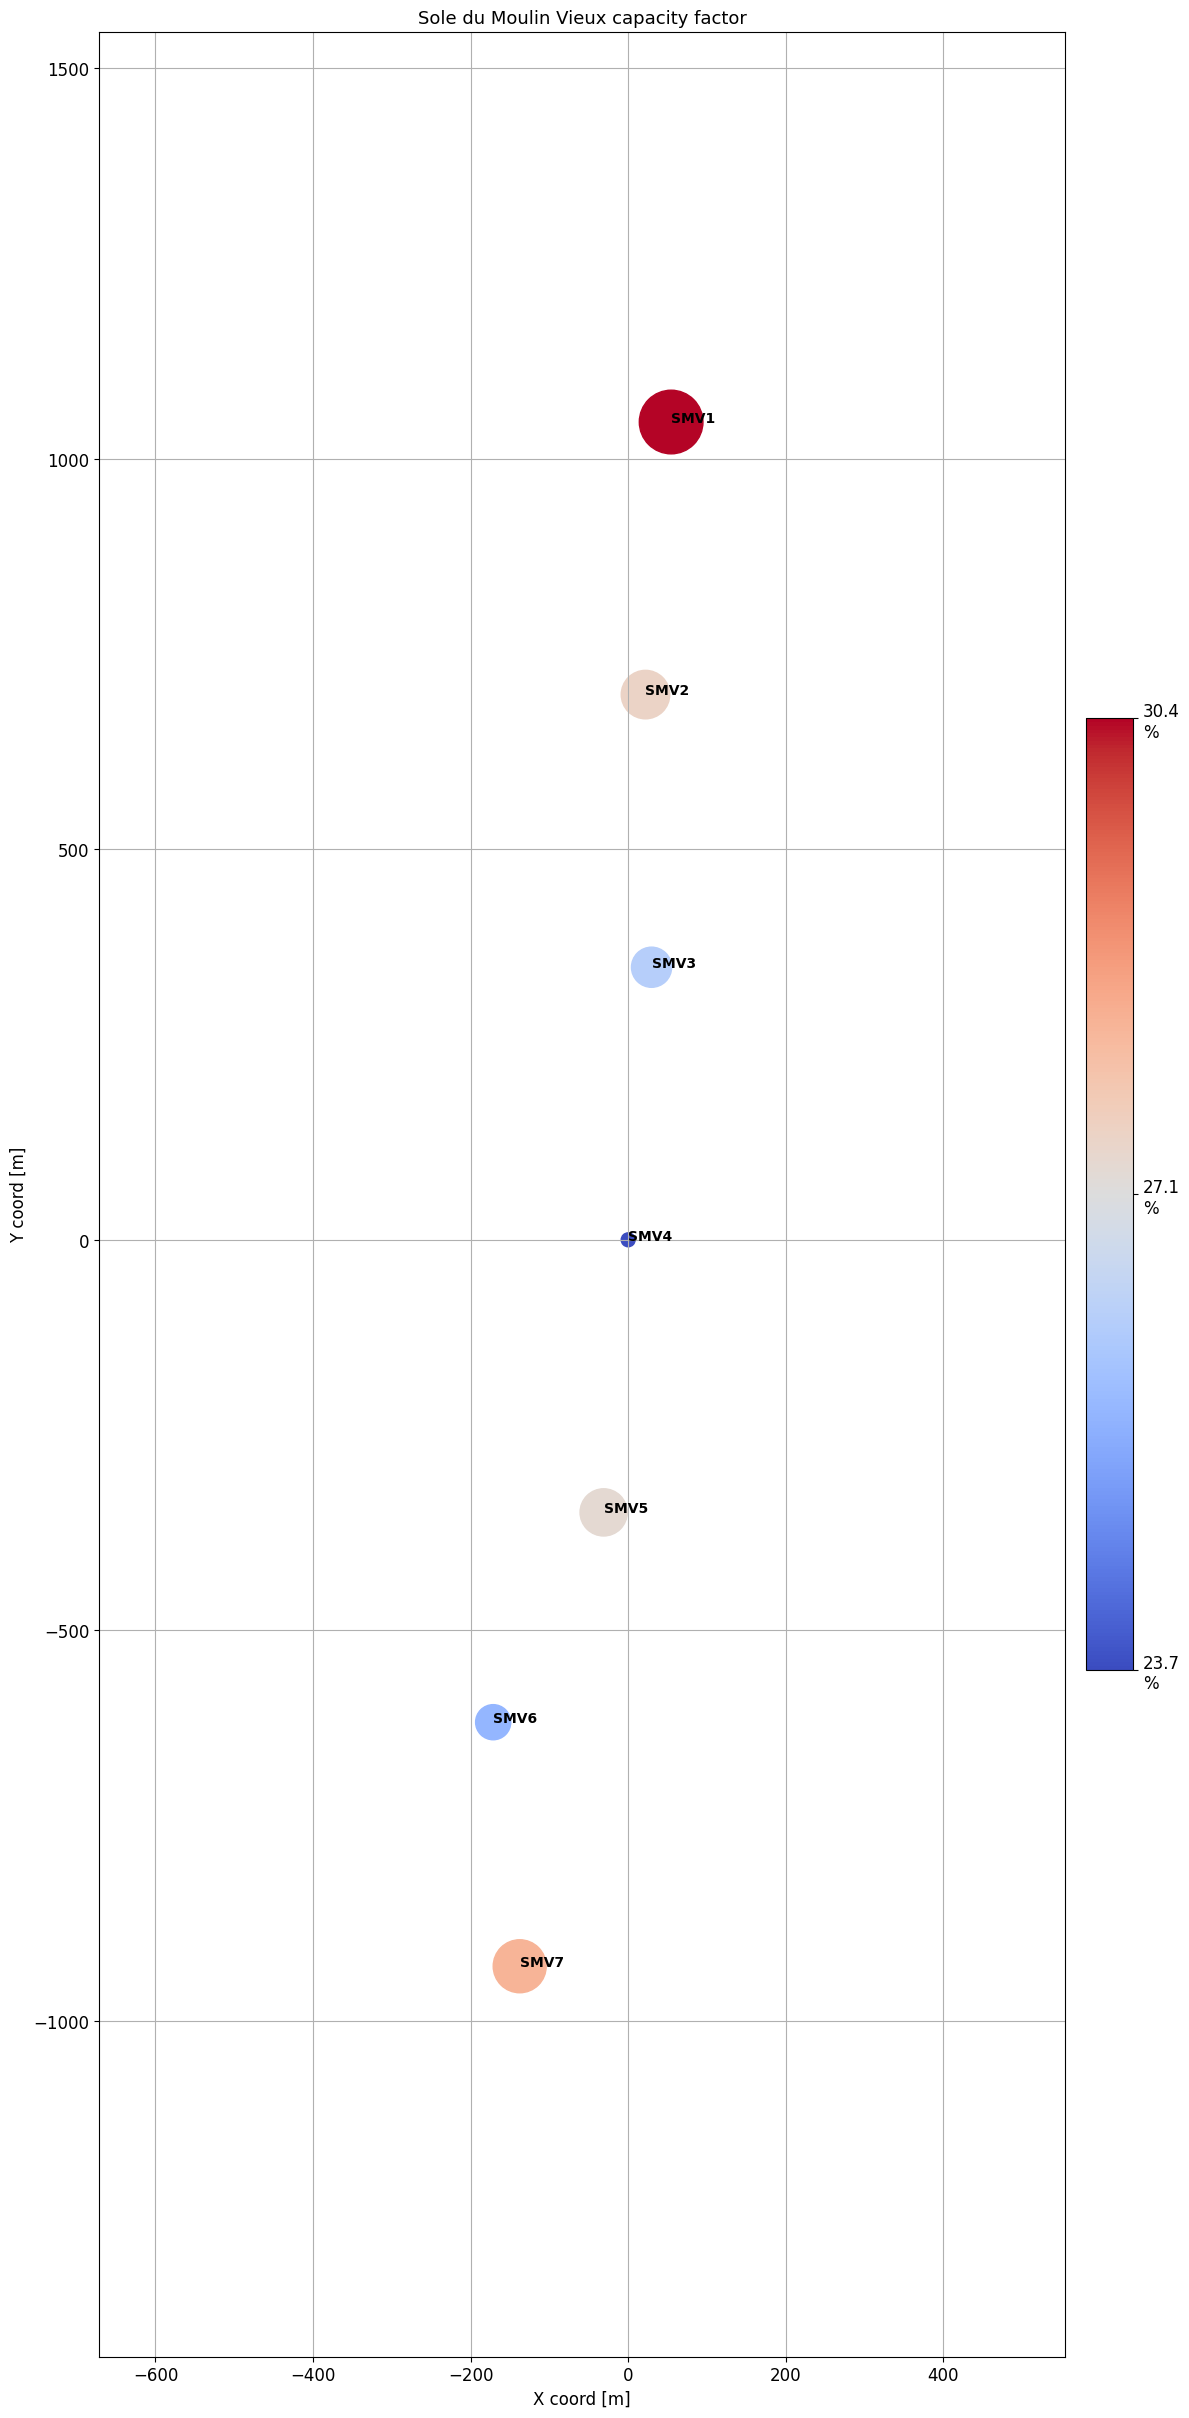

average capacity factor: 27.0%

top 3 capacity factor [%]:<br>+------+------+<br>| SMV1 | 30.4 |<br>| SMV7 | 28.3 |<br>| SMV2 | 27.5 |<br>+------+------+

bottom 3 capacity factor [%]:<br>+------+------+<br>| SMV4 | 23.7 |<br>| SMV6 | 25.5 |<br>| SMV3 | 26.2 |<br>+------+------+

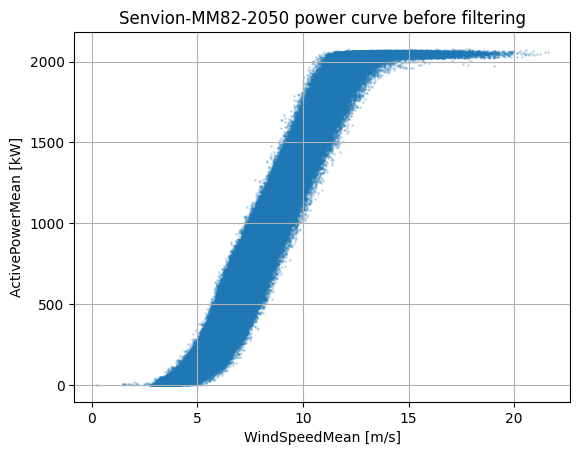

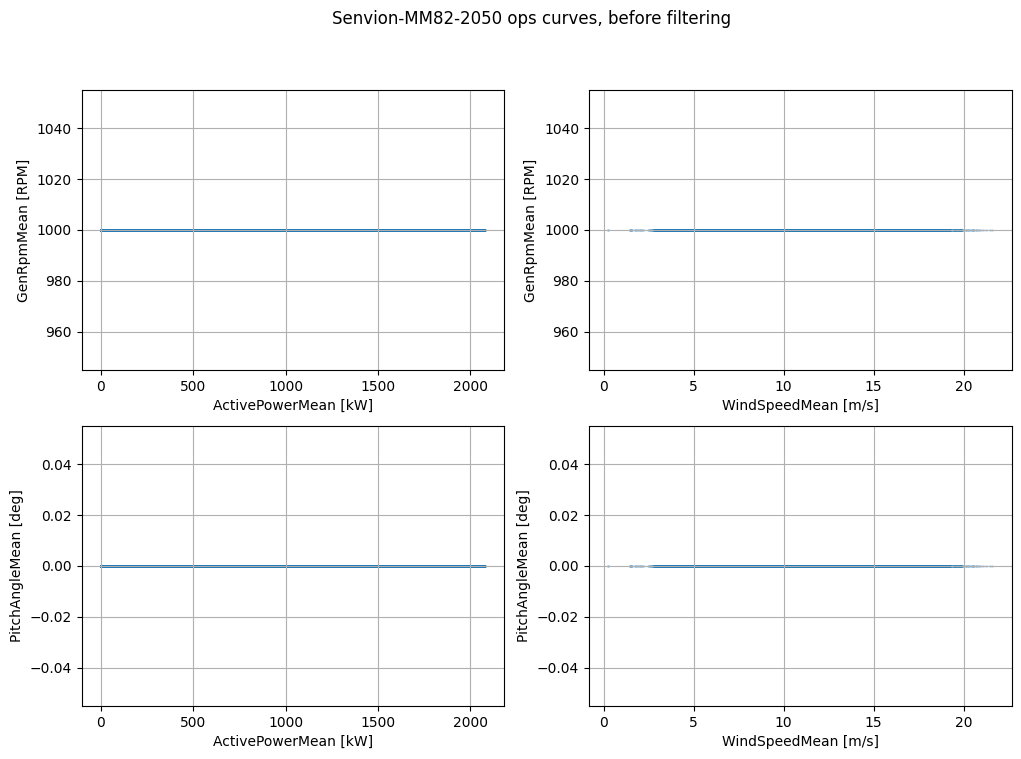

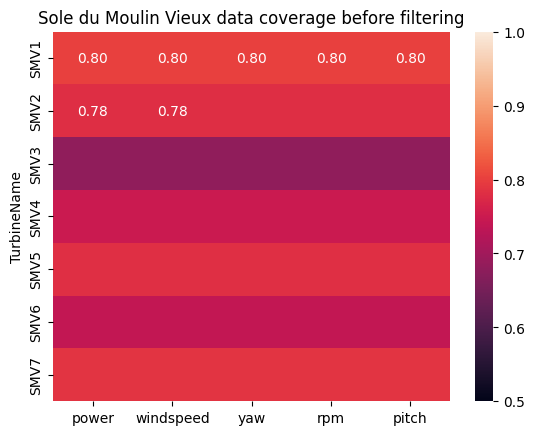

226026 rows [24.0%] of power data is missing before filtering

filter_stuck_data set 0 rows [0.0%] to NA

filter_bad_pw_ws set 0 rows [0.0%] to NA

filter_exclusions set 0 rows [0.0%] to NA

filter_yaw_exclusions set 0 rows [0.0%] to NA yaw

filter_downtime set 0 rows [0.0%] to NA

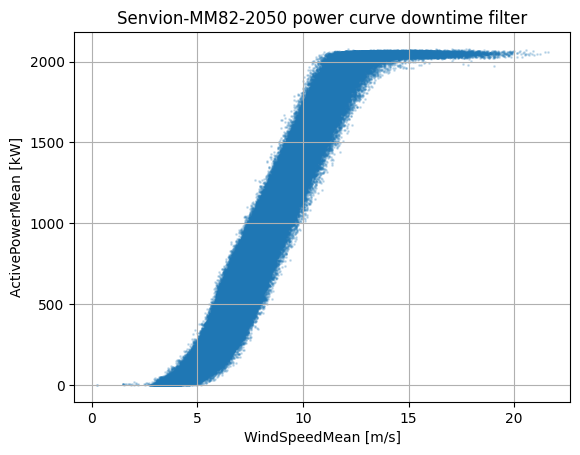

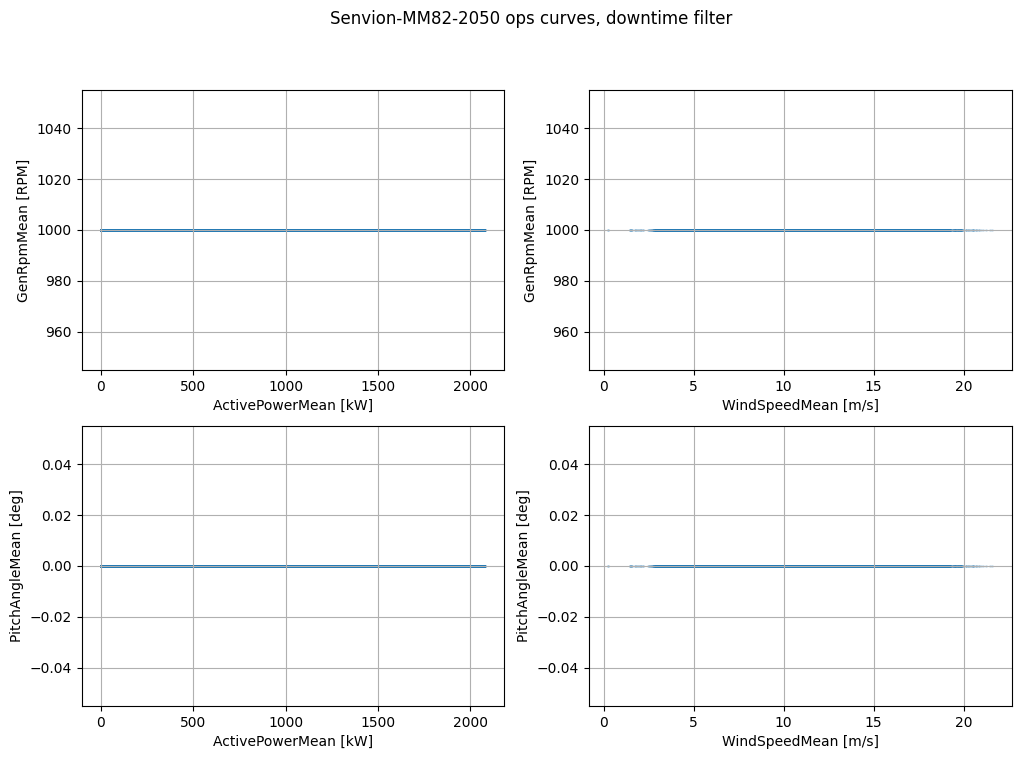

filter_missing_rpm_and_pt set 0 rows [0.0%] to NA because of rpm or pitch are NA

filter_rpm_and_pt set 0 rows [0.0%] to NA because of rpm or pitch are out of range

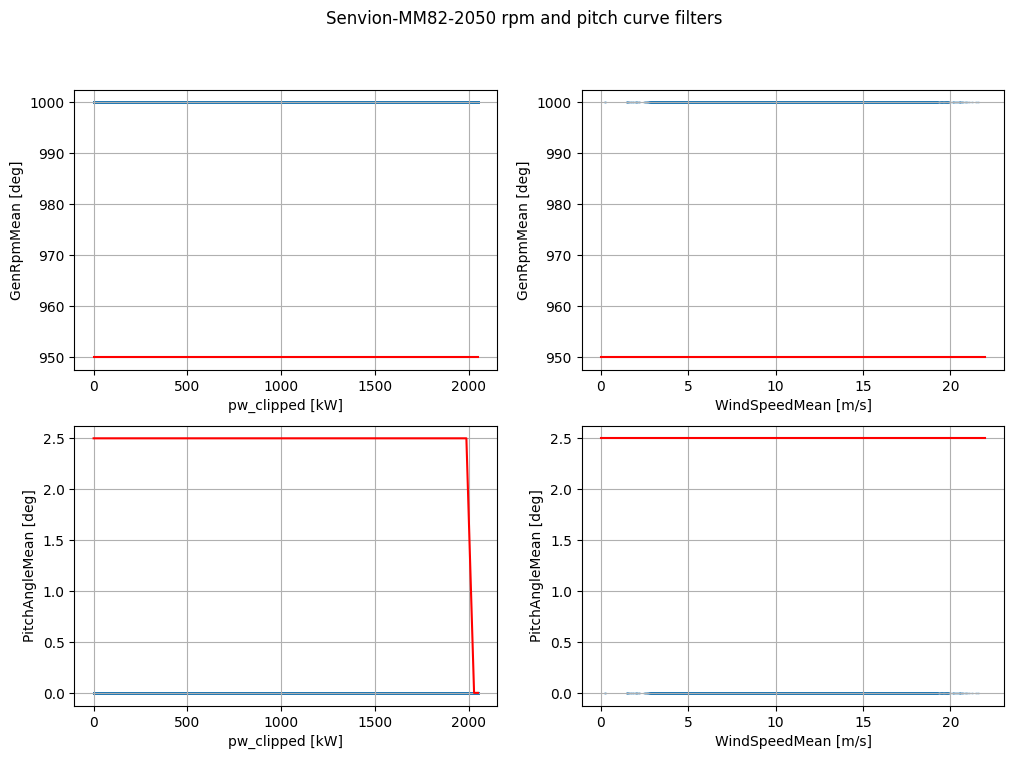

filter_rpm_and_pt set 0 rows [0.0%] to NA because of rpm or pitch curve filtering

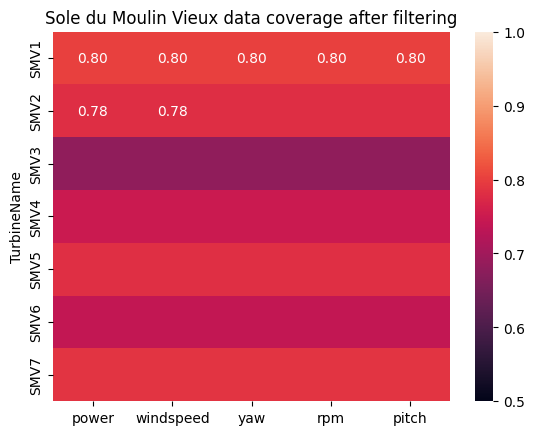

226026 rows [24.0%] of power data is missing after filtering

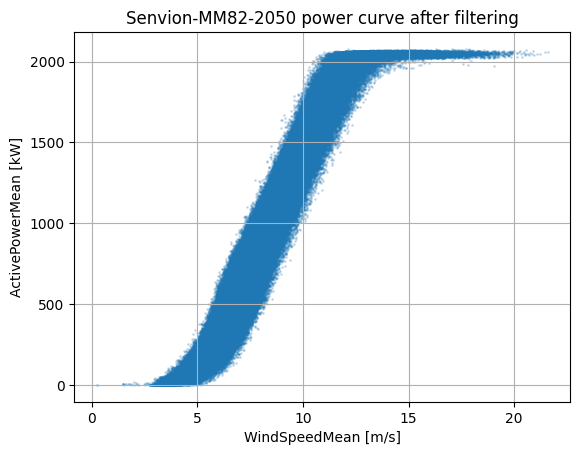

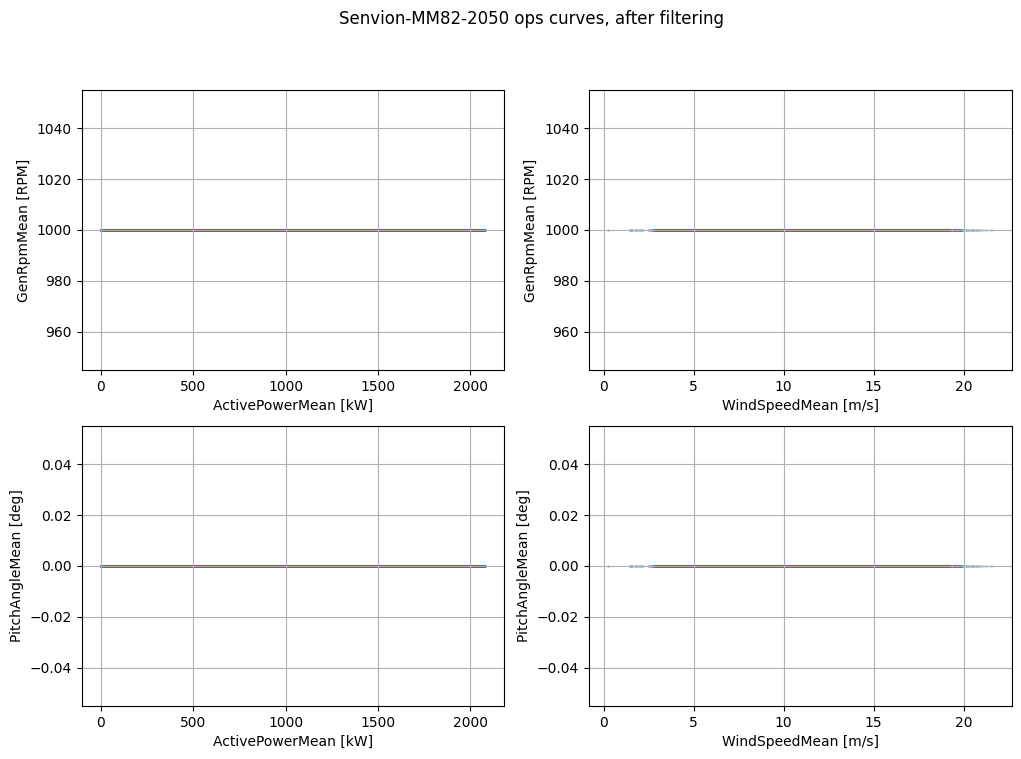

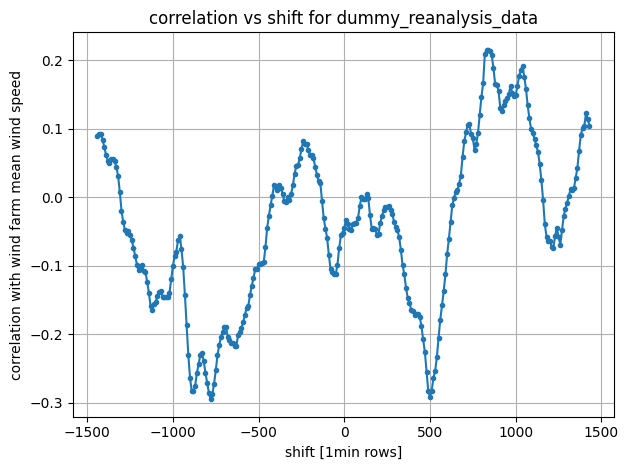

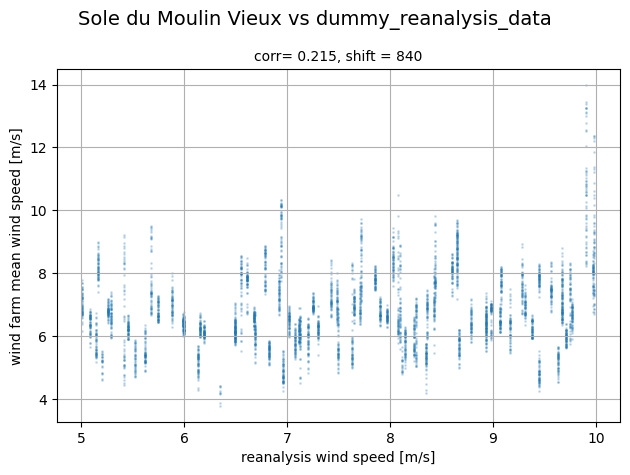

dummy_reanalysis_data best correlation is 0.215324 with a shift of 840

dummy_reanalysis_data has best correlation: 0.215 with a shift of 840

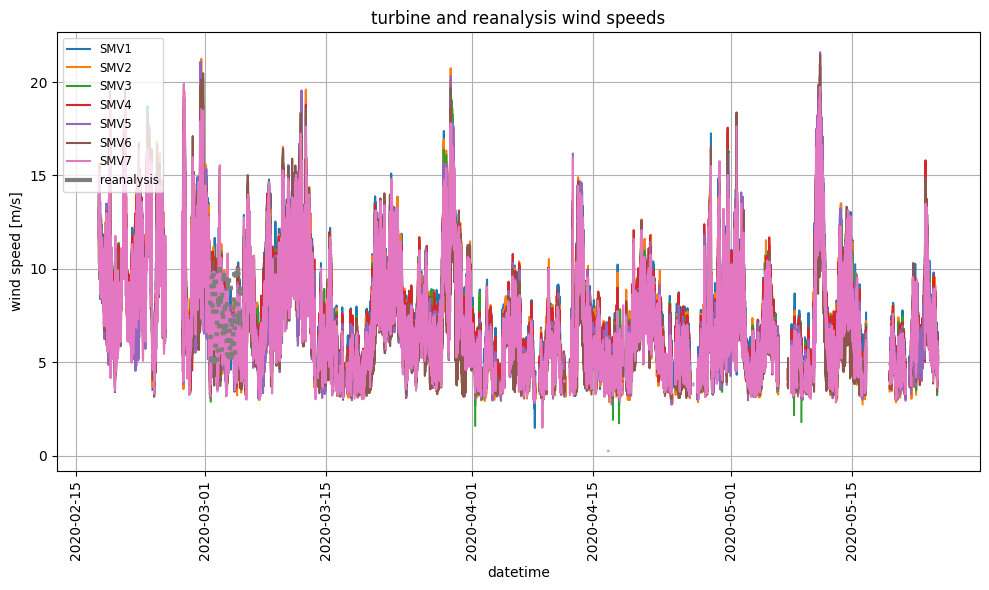

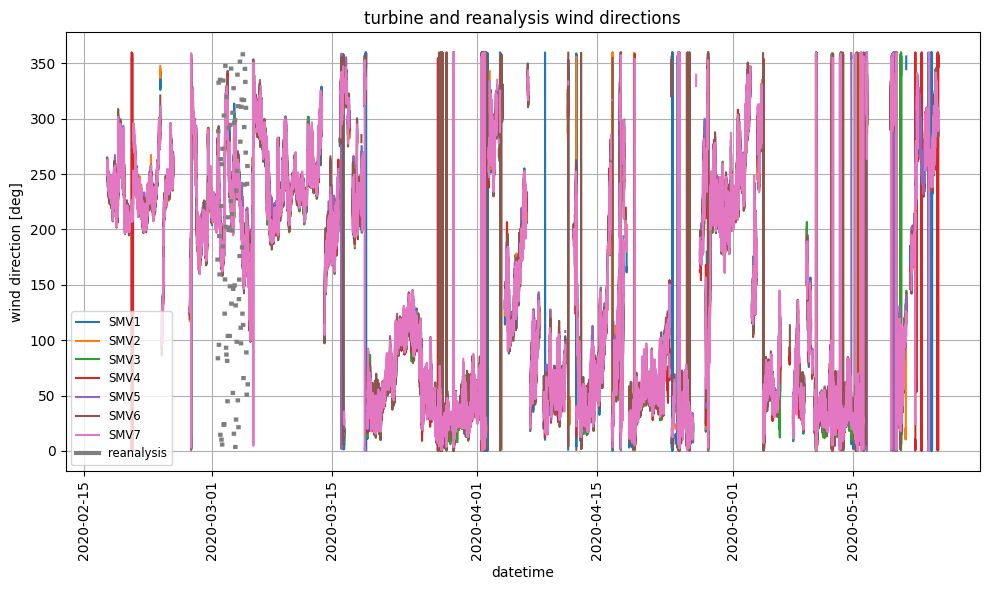

top 3 turbines needing northing correction vs reanalysis_wd before northing:<br>+------+-----+<br>| SMV1 | nan |<br>| SMV2 | nan |<br>| SMV3 | nan |<br>+------+-----+

top 3 REFERENCE turbines needing northing correction vs reanalysis_wd before northing:<br>+------+-----+<br>| SMV7 | nan |<br>+------+-----+

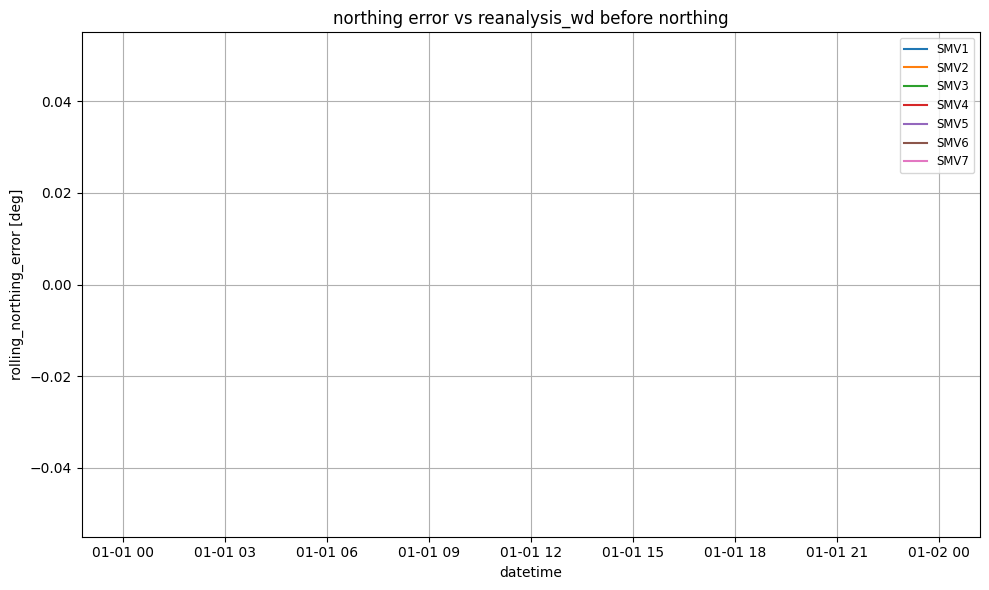

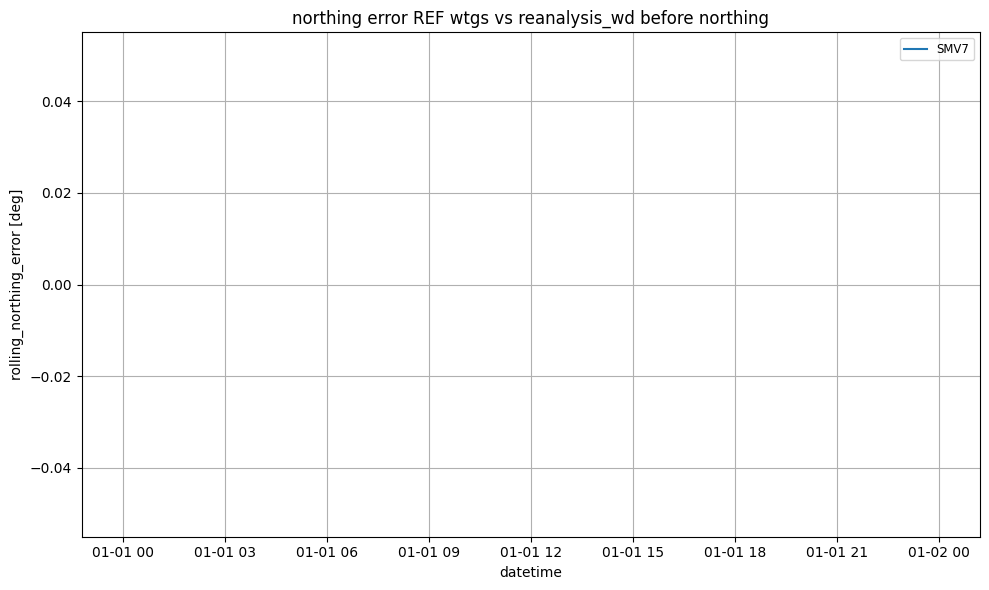

no northing corrections to apply

applied 0 northing corrections

top 3 turbines needing northing correction vs reanalysis_wd after northing:<br>+------+-----+<br>| SMV1 | nan |<br>| SMV2 | nan |<br>| SMV3 | nan |<br>+------+-----+

top 3 REFERENCE turbines needing northing correction vs reanalysis_wd after northing:<br>+------+-----+<br>| SMV7 | nan |<br>+------+-----+

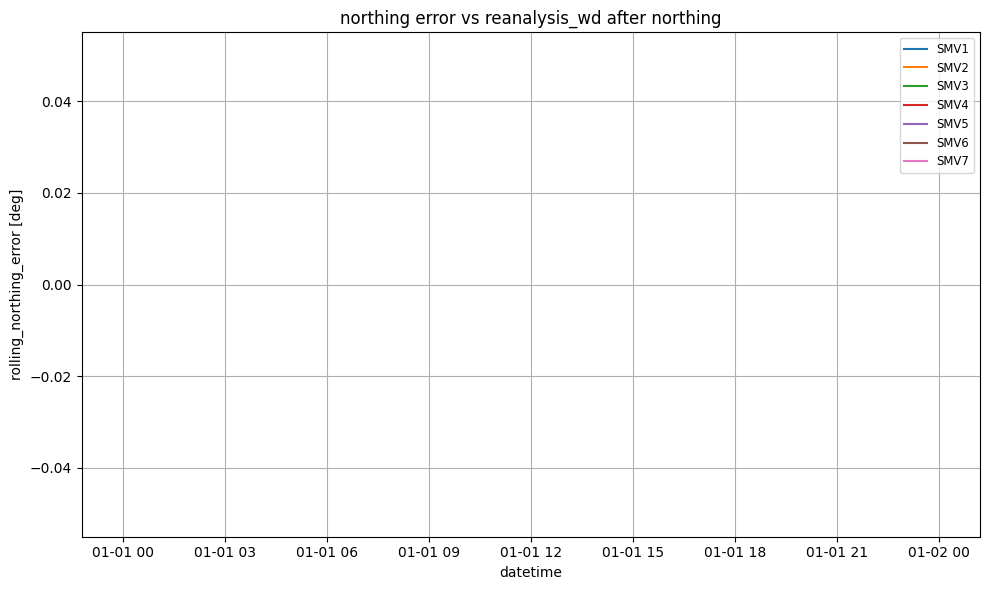

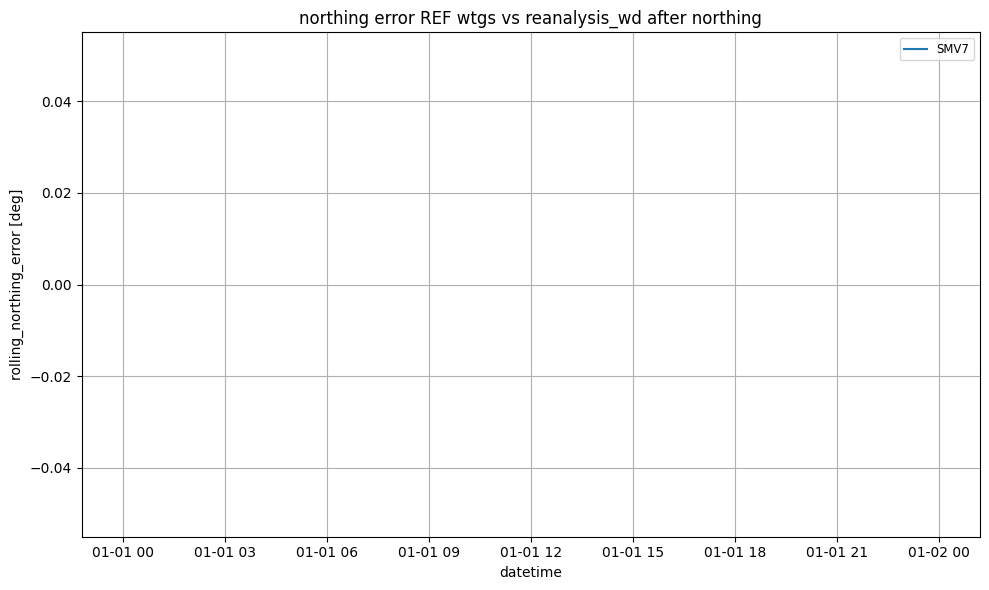

estimated rated wind speed = 13.7 m/s

estimated cut-in wind speed = 2.9 m/s

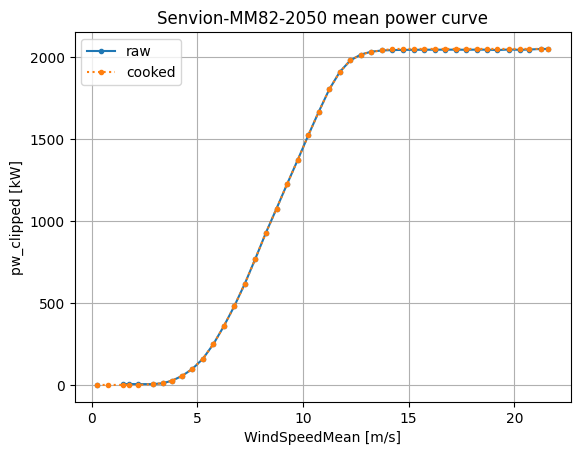

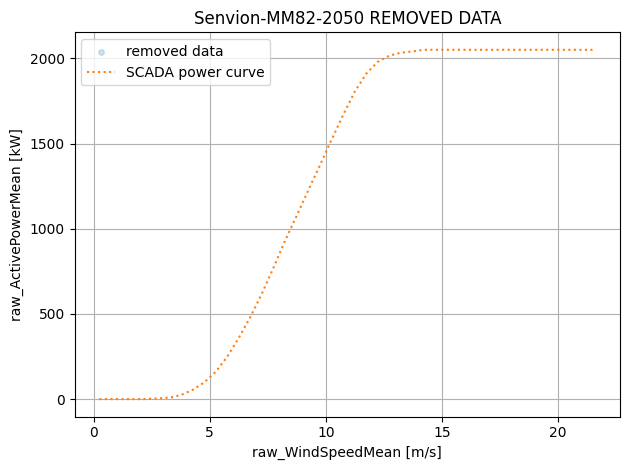

##############################################################################<br># estimate wind speed from power<br>##############################################################################

SMV1 cp correction factor = 0.97

SMV2 cp correction factor = 0.99

SMV3 cp correction factor = 1.00

SMV4 cp correction factor = 0.98

SMV5 cp correction factor = 1.02

SMV6 cp correction factor = 1.03

SMV7 cp correction factor = 1.02

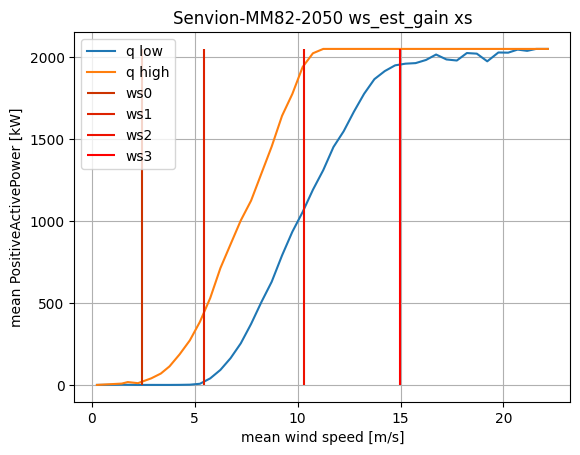

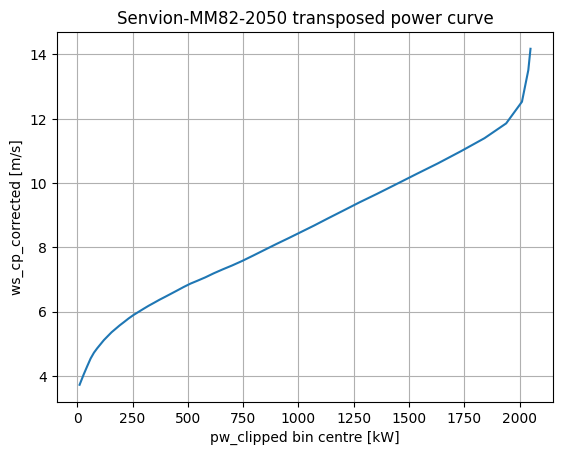

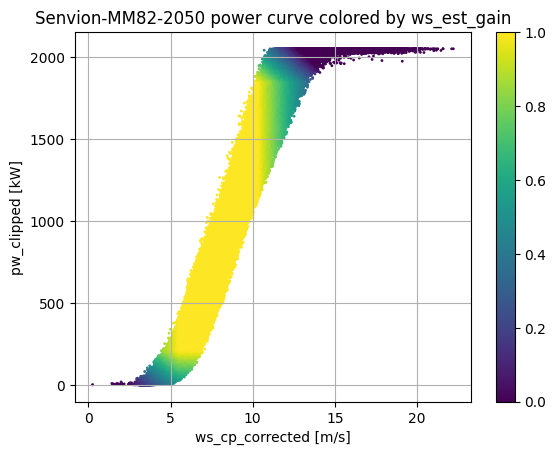

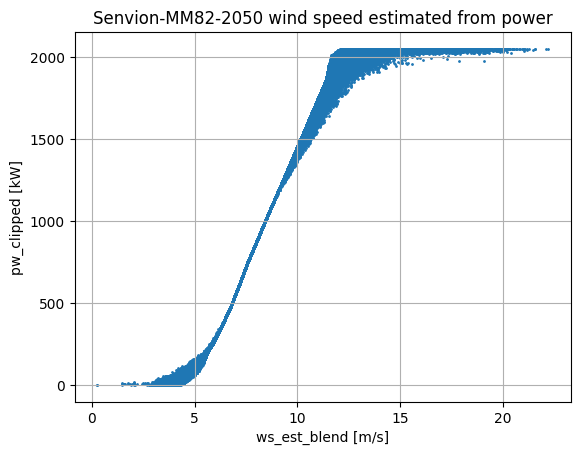

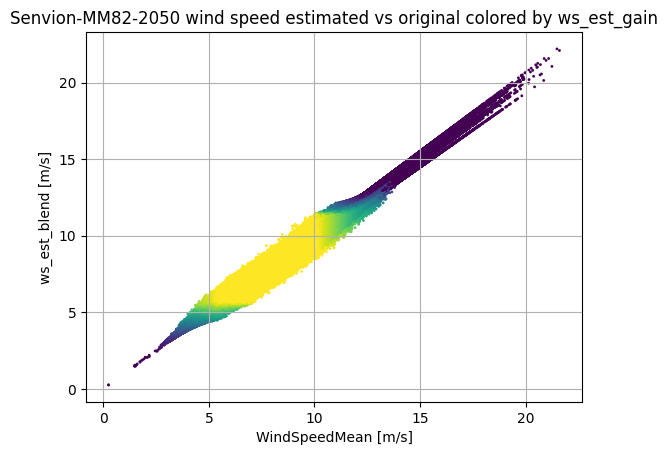

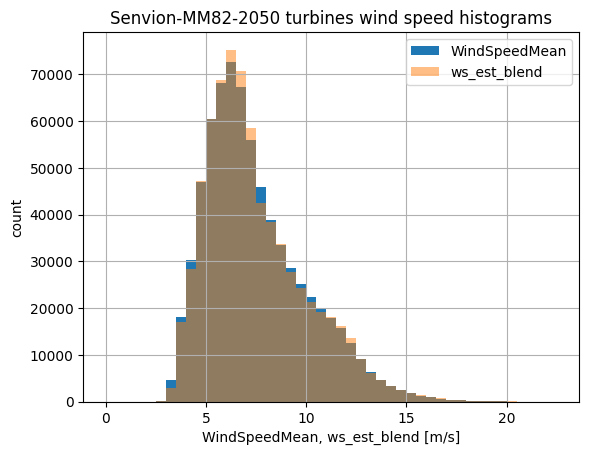

Senvion-MM82-2050 76.0% of rows are waking

Senvion-MM82-2050 0.0% of rows are not waking

Senvion-MM82-2050 24.0% of rows have unknown or partial waking

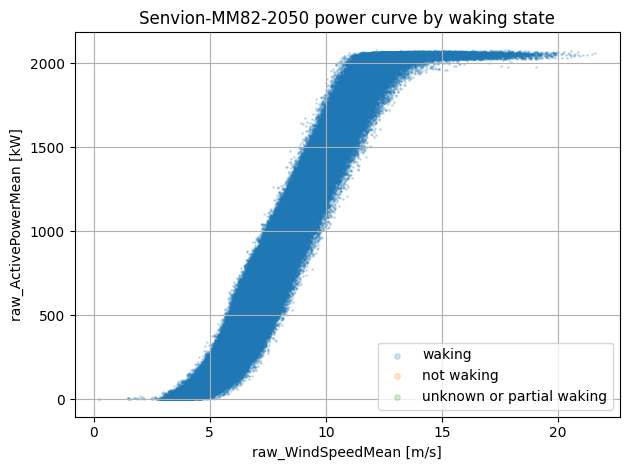

In [12]:
from wind_up.interface import AssessmentInputs

assessment_inputs = AssessmentInputs.from_cfg(
    cfg=cfg,
    plot_cfg=plot_cfg,
    toggle_df=toggle_df,
    scada_df=scada_df,
    metadata_df=metadata_df,
    reanalysis_datasets=[reanalysis_dataset],
    cache_dir=None,
)

# Run wind-up analysis

The wind-up analysis calculates the uplift of each test turbine relative to each reference and the uplift of the references (which should be 0%) if there is more than one. The basic steps are a) directional detrending which is similar to IEC61400-12-1 site calibration, b) measure power curves for toggle off and toggle on data, c) calculate the energy uplift and uncertainty.

In this case there are two test-ref combinations (SMV6-SMV7 and SMV6-SMV7).

test turbines: ['SMV6', 'SMV5']

ref list: ['SMV7']

turbines to test: ['SMV6', 'SMV5']

filter_all_test_wtgs_together SMV5 set 3275 rows [2.4%] to NA

could not calculate rolling windspeed diff

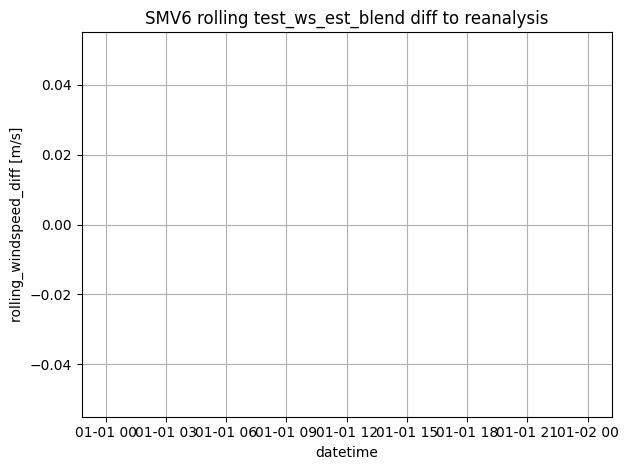

changed 2899 [5.5%] rows from toggle_on True to False because toggle_change_settling_filter_seconds = 120

changed 2828 [3.5%] rows from toggle_off True to False because toggle_change_settling_filter_seconds = 120

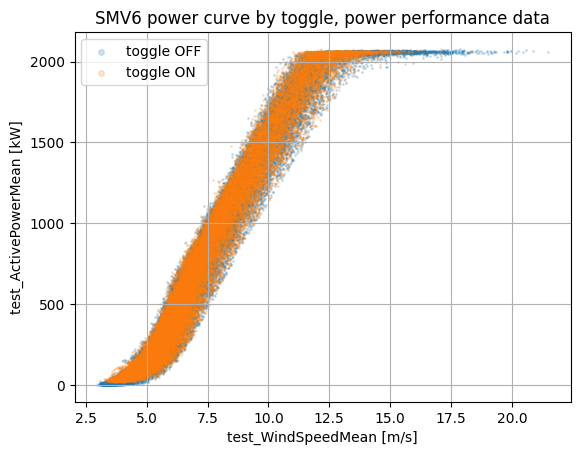

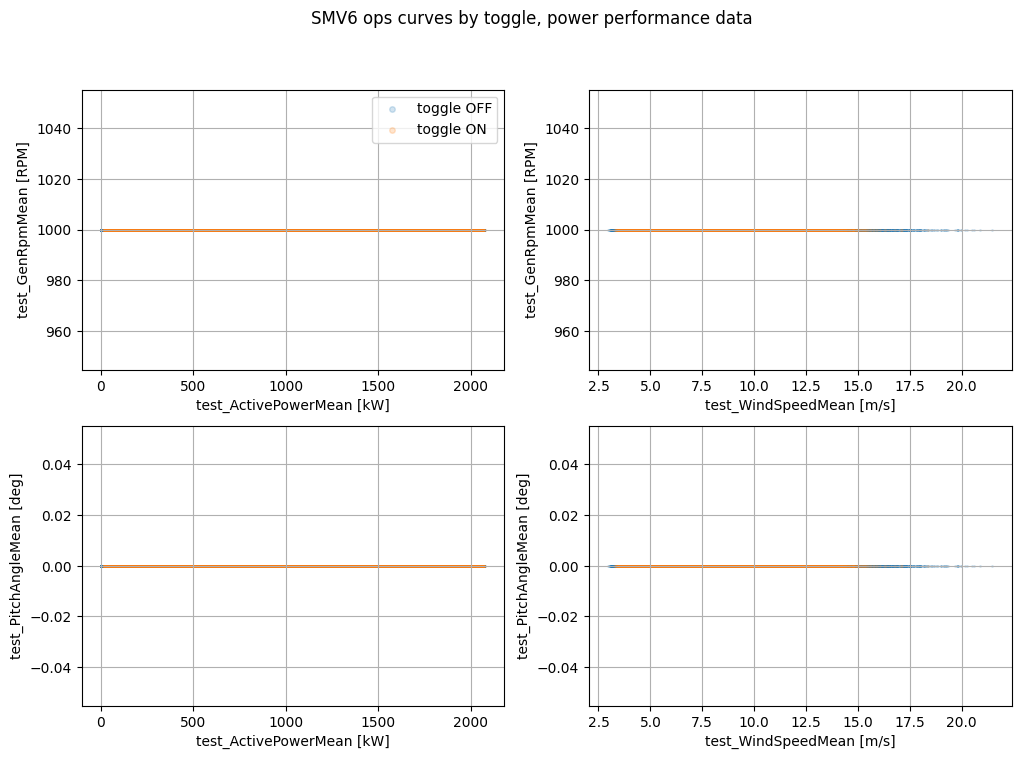

analysing SMV6 SMV7, loop_counter=0

changed 2899 [5.5%] rows from toggle_on True to False because toggle_change_settling_filter_seconds = 120

changed 2828 [3.5%] rows from toggle_off True to False because toggle_change_settling_filter_seconds = 120

removed 115061 [85.4%] rows from ref_df using ref_wd_filter

SMV7 wake free directions with data min=203.0 max=240.0

removed 0 [0.0%] rows from ref_df using require_ref_wake_free

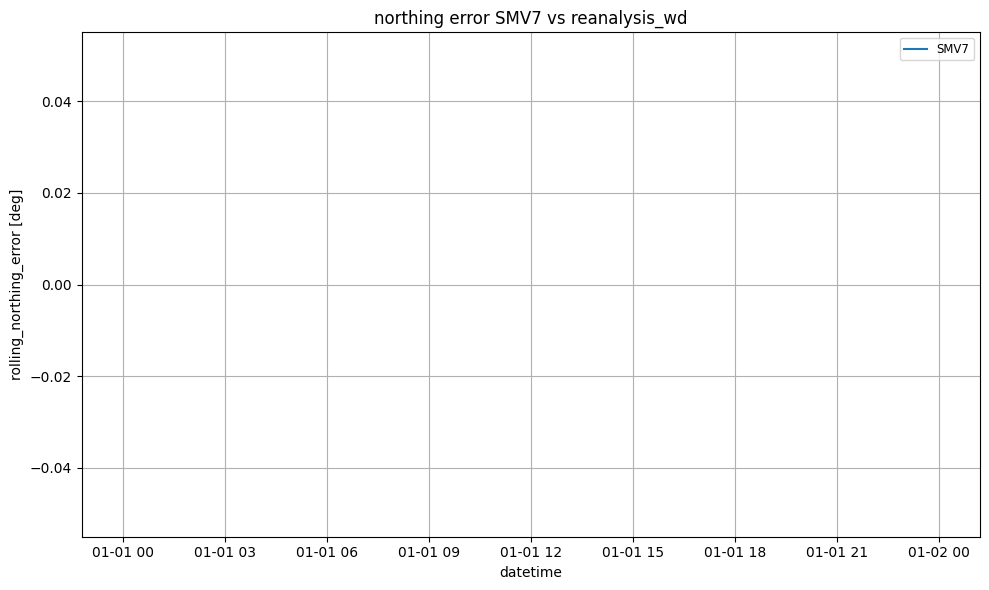

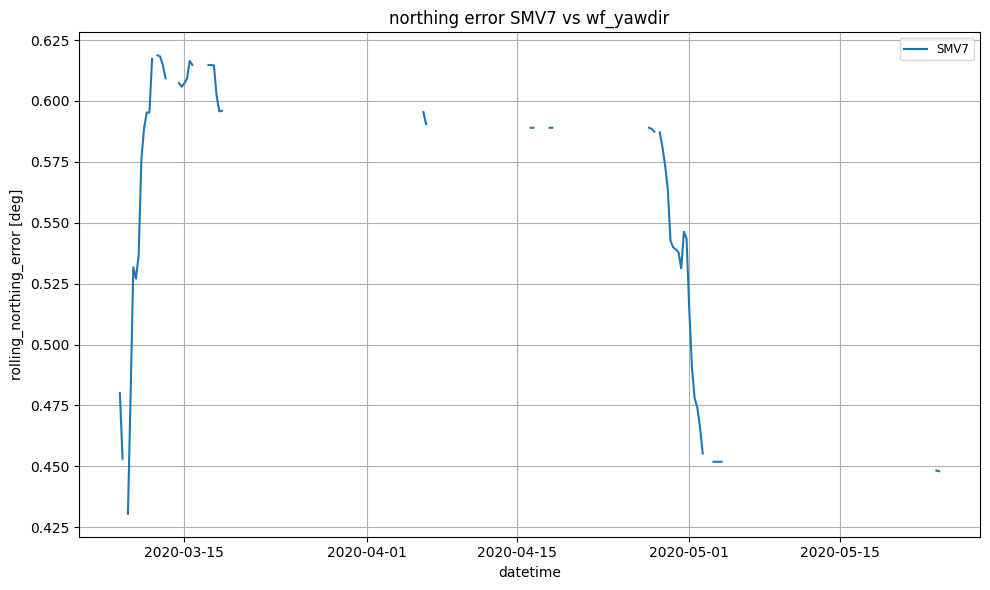

could not calculate rolling windspeed diff

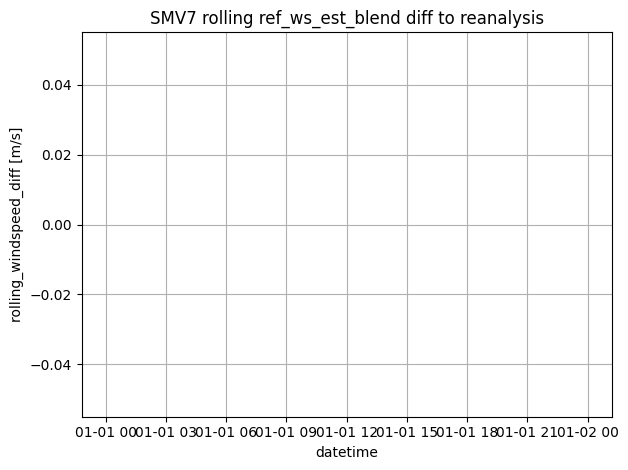

removed 55533 [41.2%] rows from detrend_df where test_toggle_off was not True after the first toggle on time

top 1 SMV6 SMV7 waking scenarios [%]:

+--------------+-------+<br>| none offline | 100.0 |<br>+--------------+-------+

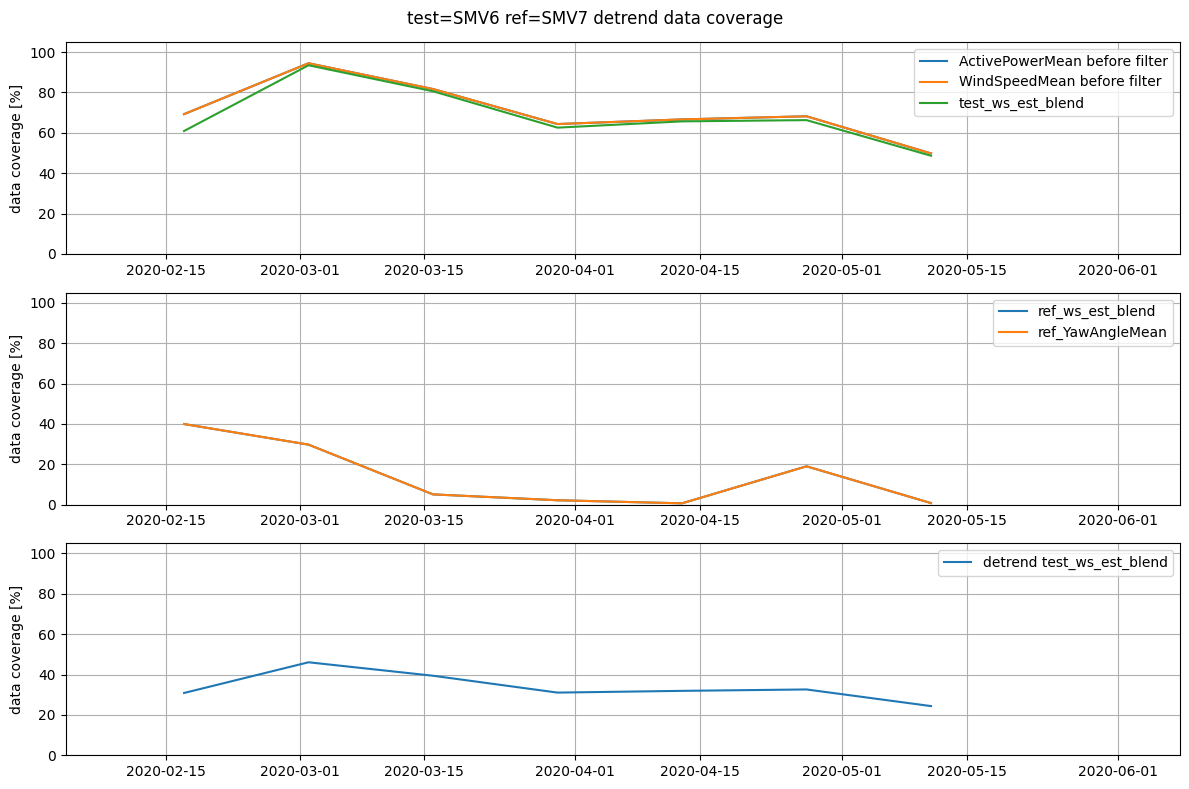

removed 0 bad detrend results

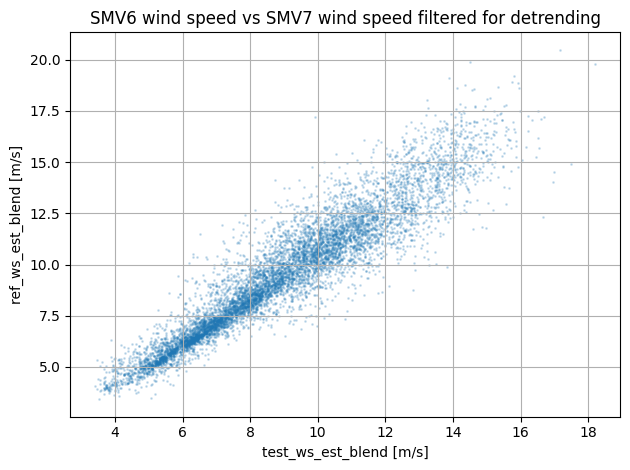

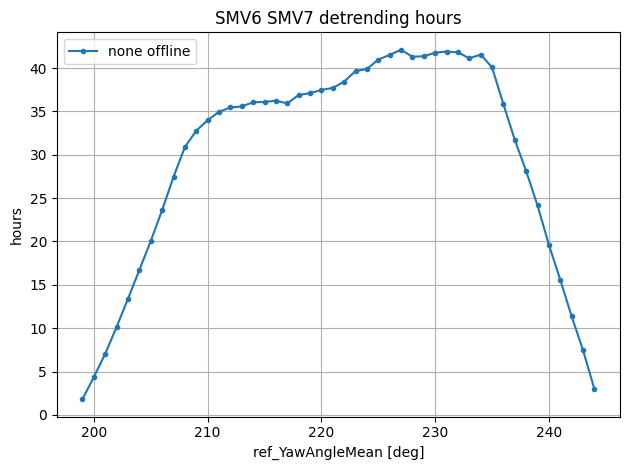

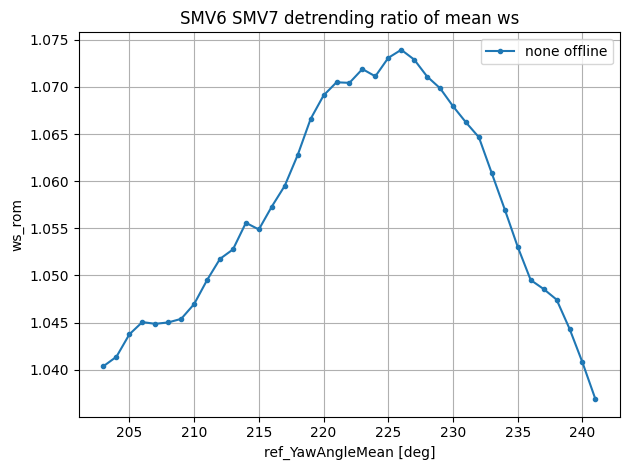

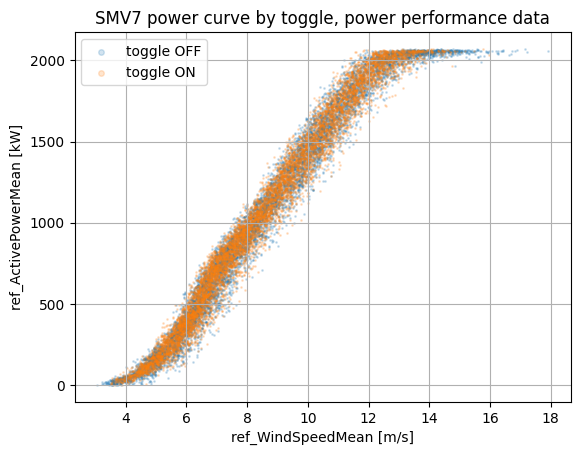

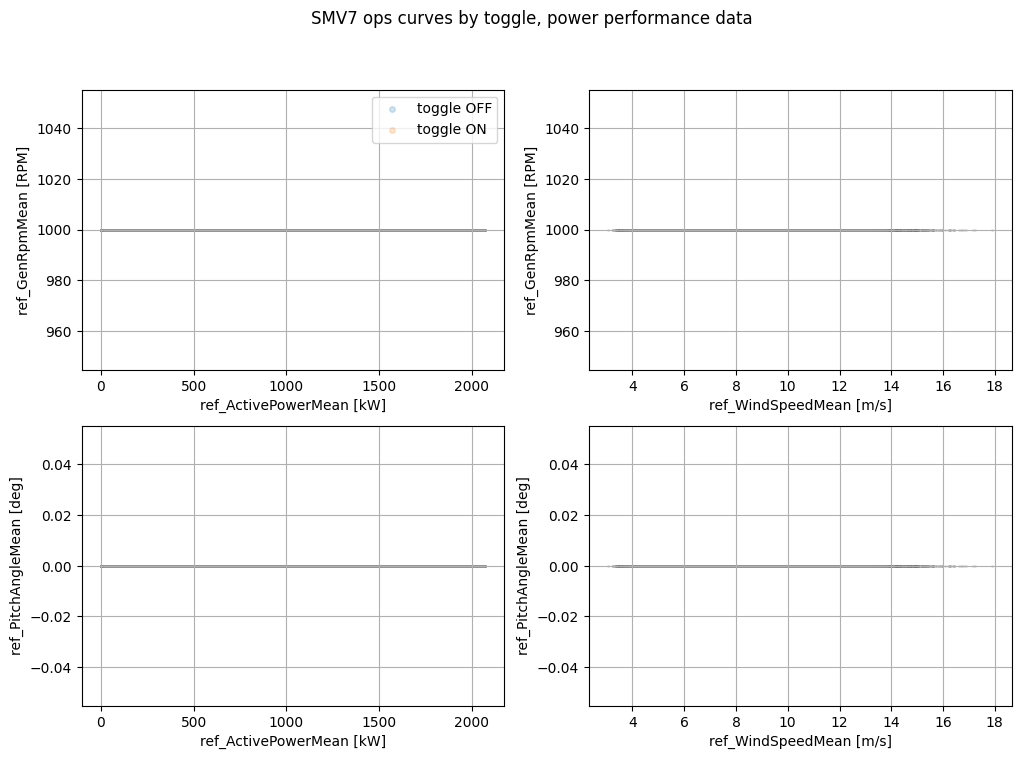

top 1 SMV6 SMV7 waking scenarios [%]:

+--------------+-------+<br>| none offline | 100.0 |<br>+--------------+-------+

top 1 SMV6 SMV7 waking scenarios [%]:

+--------------+-------+<br>| none offline | 100.0 |<br>+--------------+-------+

detrend applied to 38 scenario - directions

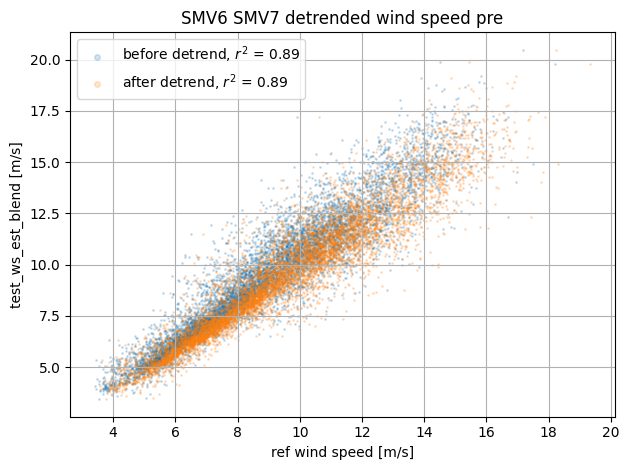

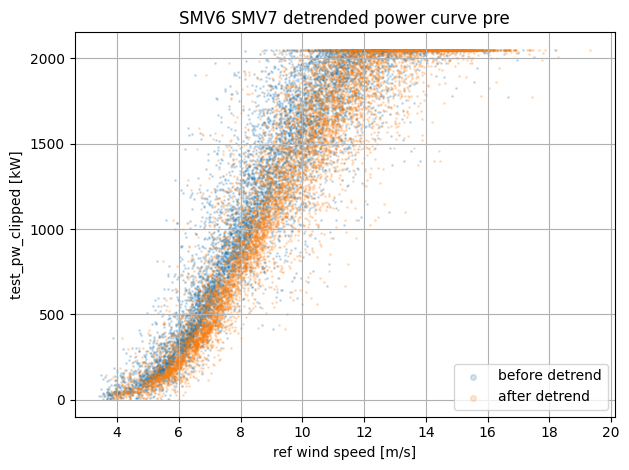

detrend applied to 38 scenario - directions

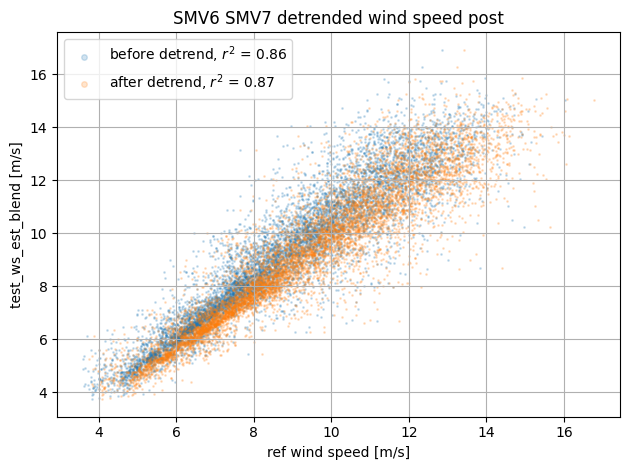

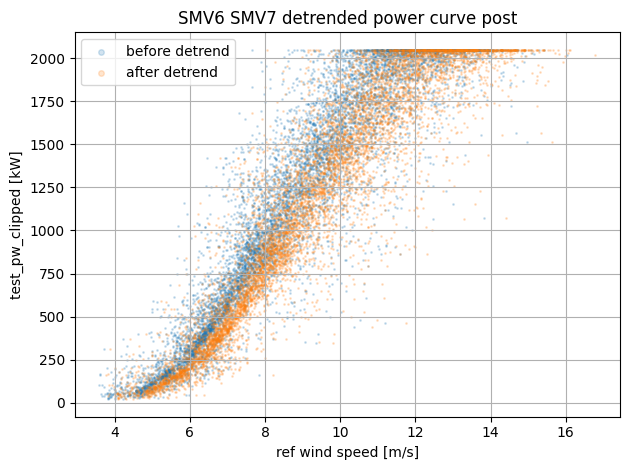

detrend improved pre_df ws r2 by 0.00 (0.89 to 0.89)

detrend improved post_df ws r2 by 0.00 (0.86 to 0.87)

removed 0 bad detrend results

removed 0 bad detrend results

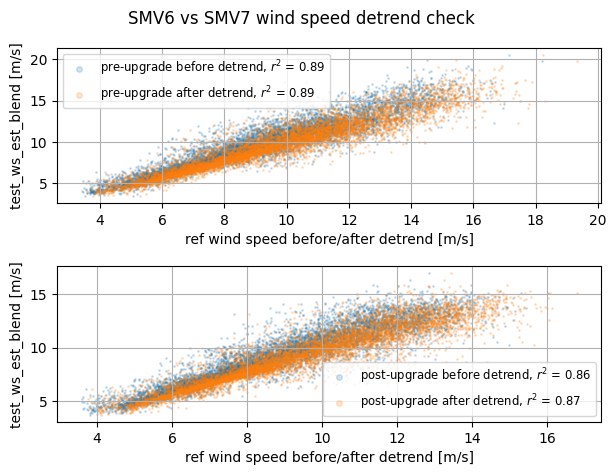

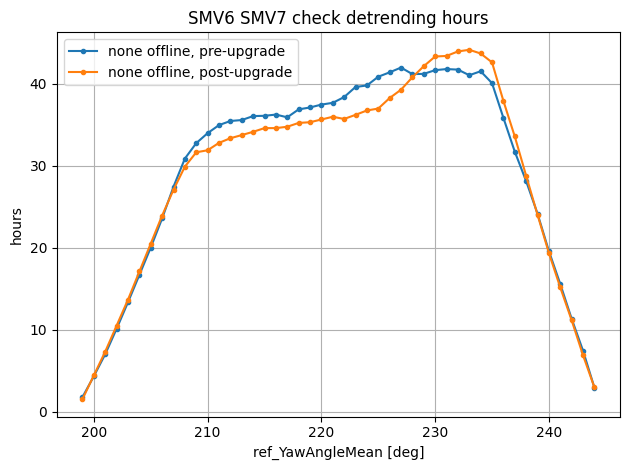

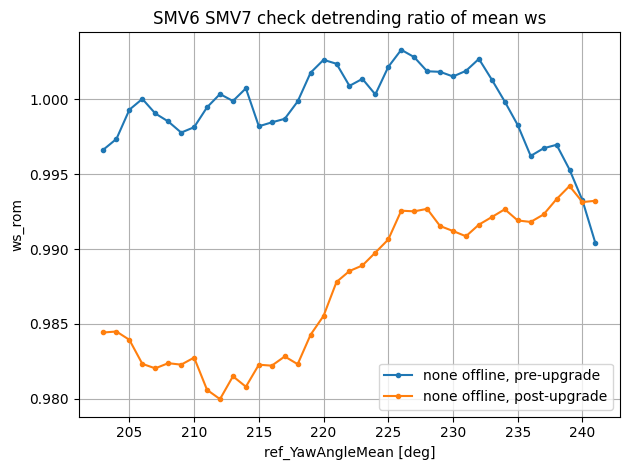

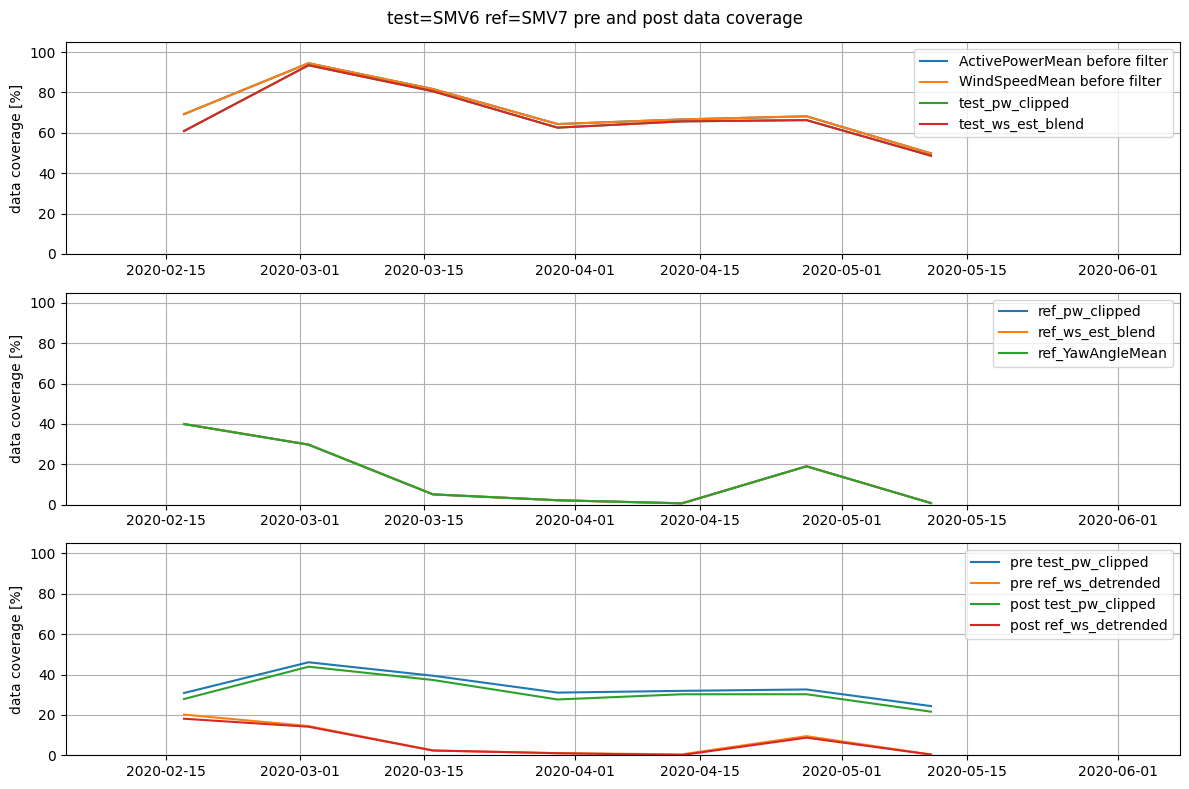

removed 262 [3.1%] rows from pre_df using any_within_timedelta pairing filter

removed 79 [1.0%] rows from post_df using any_within_timedelta pairing filter

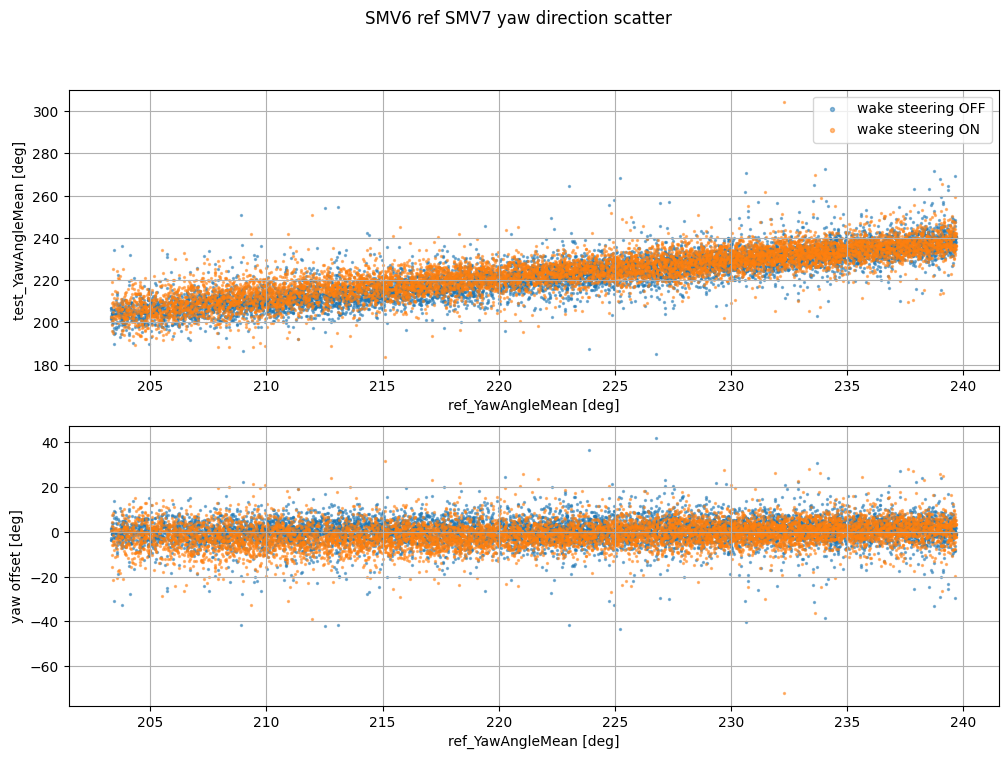

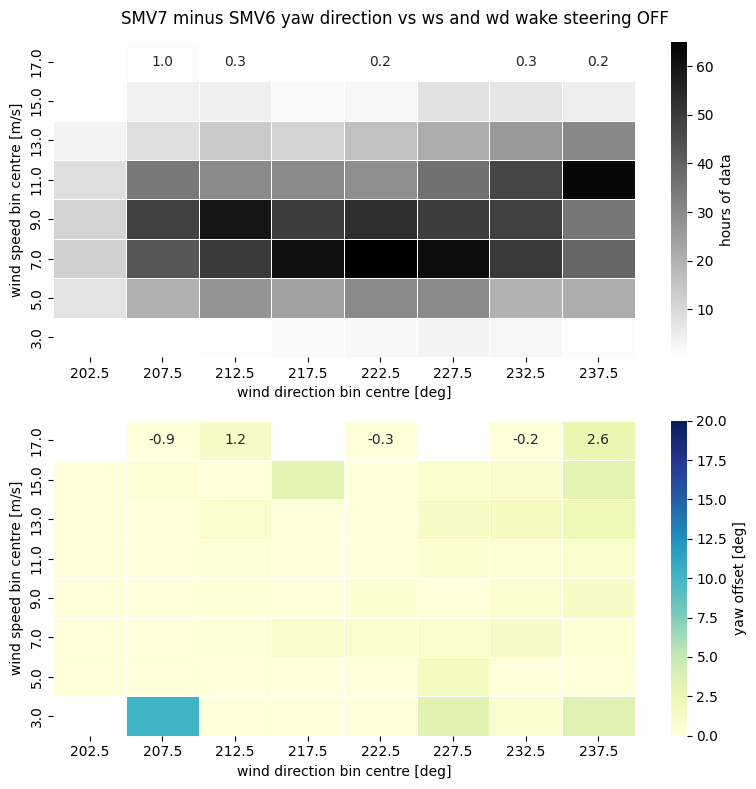

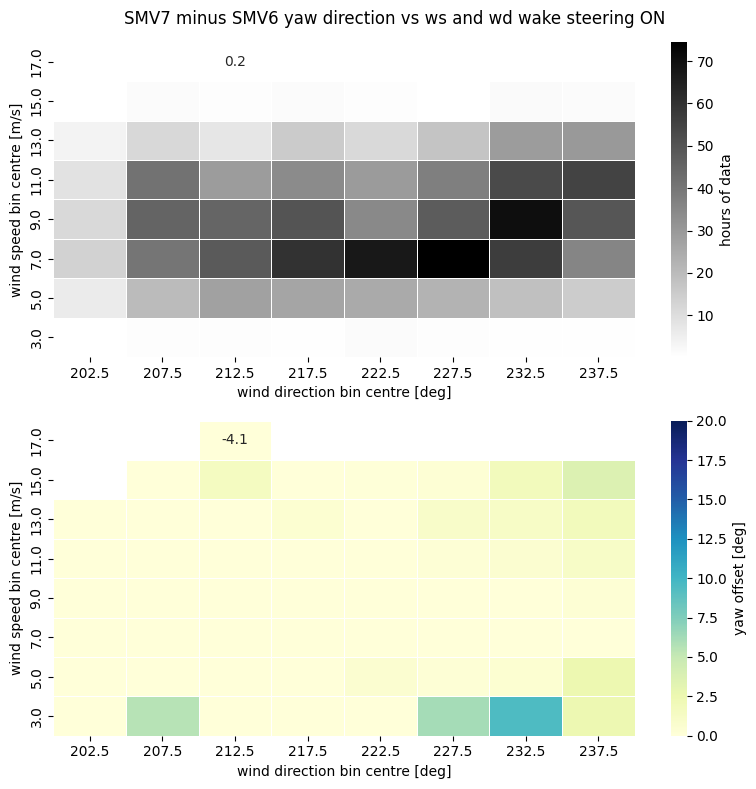

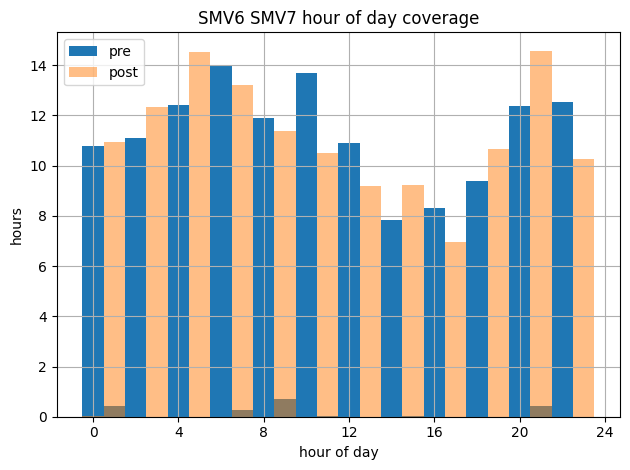

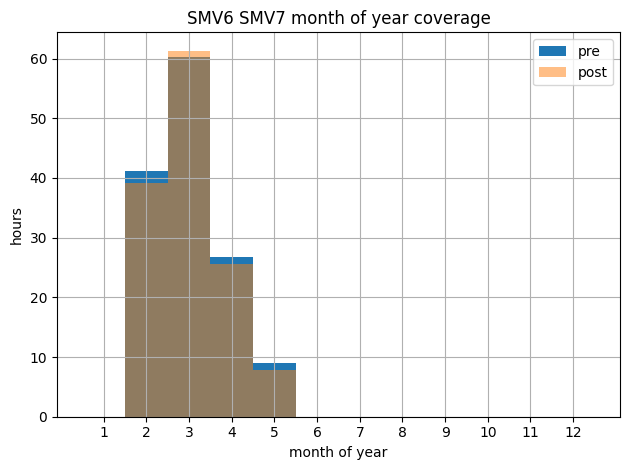

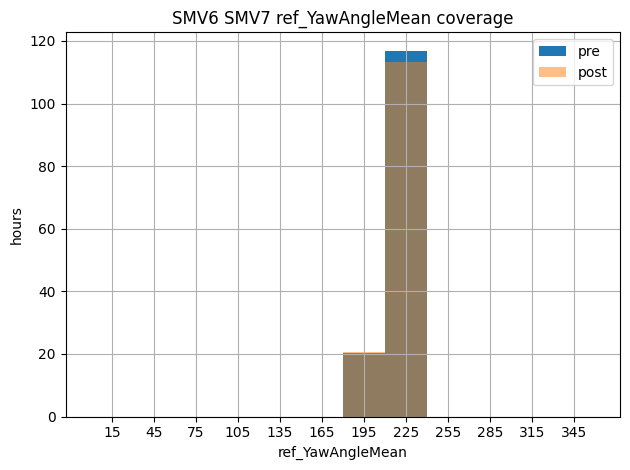

plot_pre_post_condition_histogram ref_name=SMV7 pre_df missing required column ref_AmbientTemp

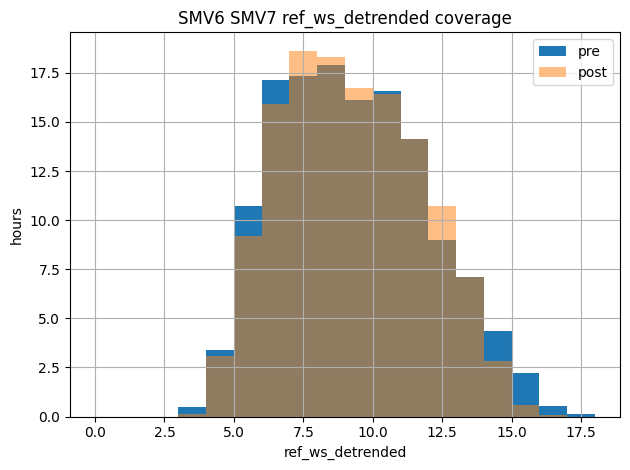

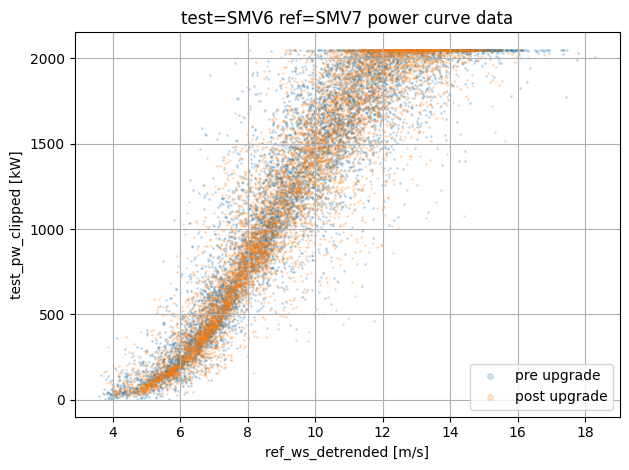

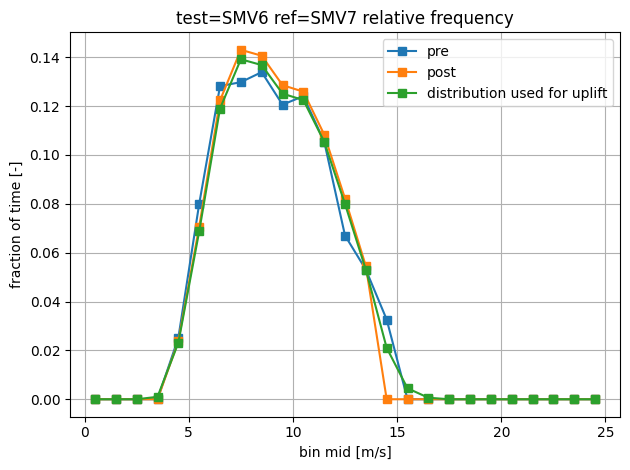

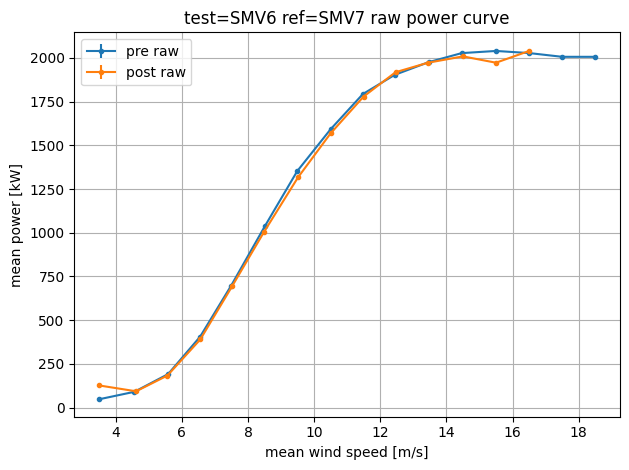

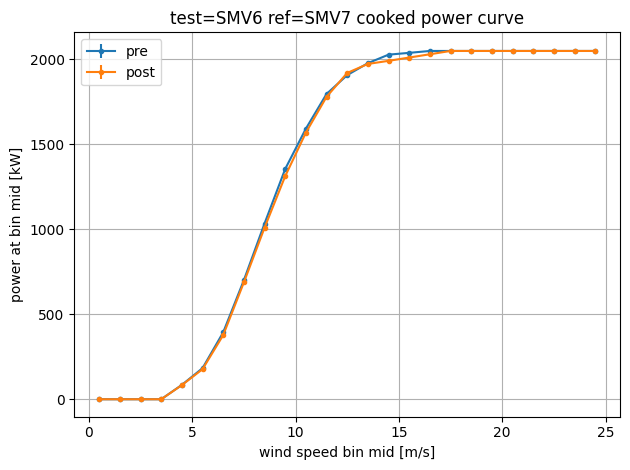

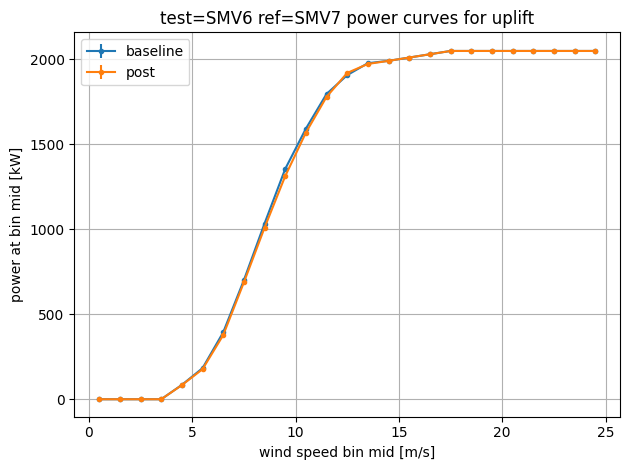

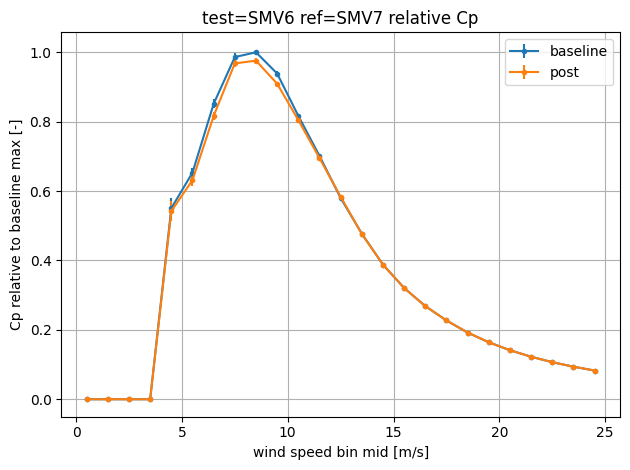

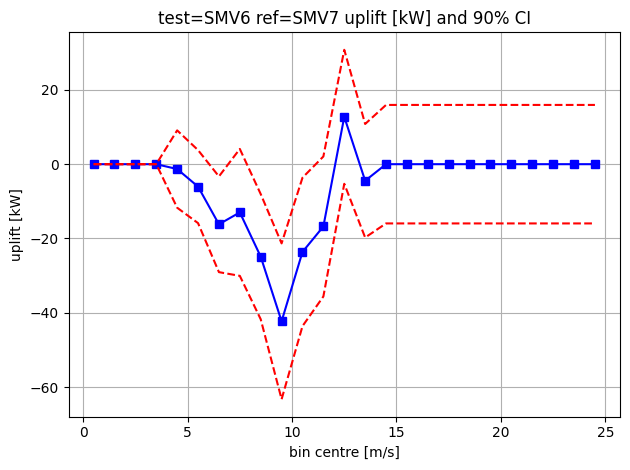

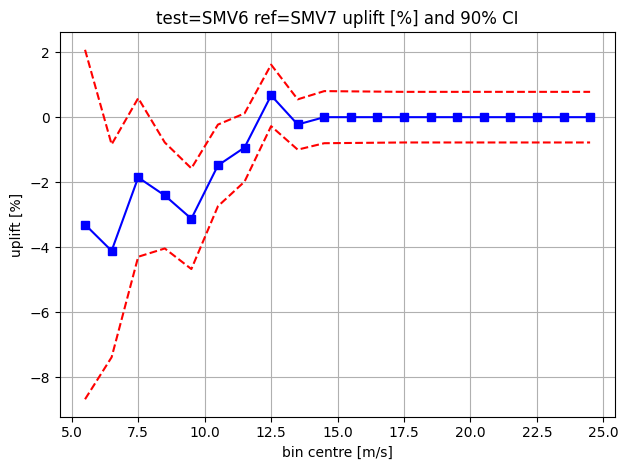

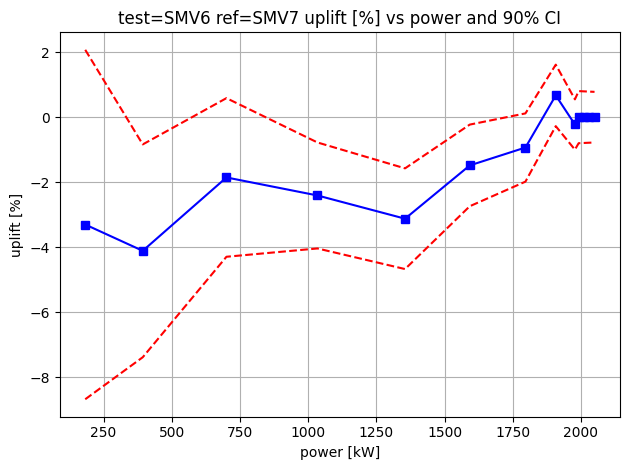

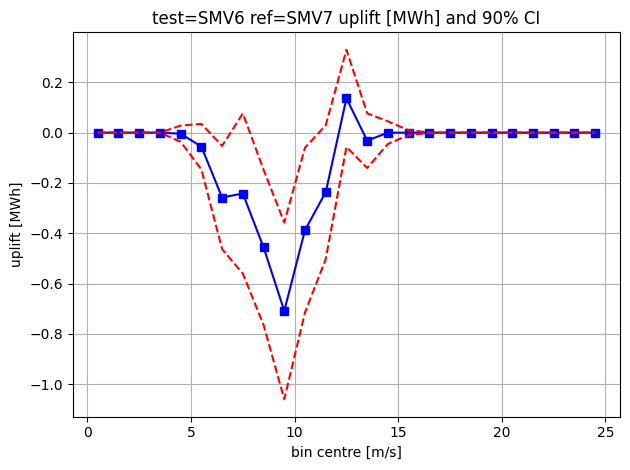

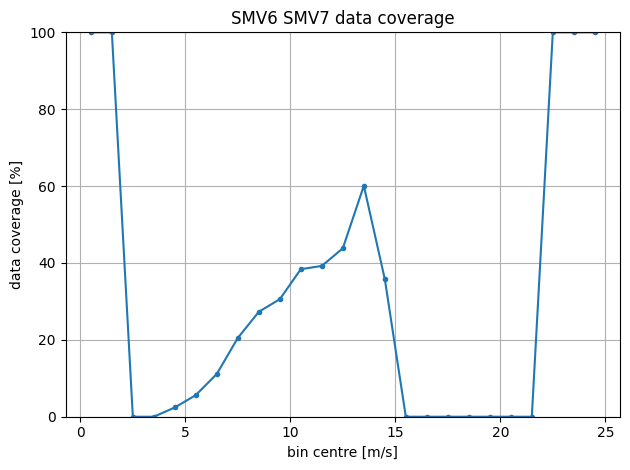

<br>results for test=SMV6 ref=SMV7:<br>

hours pre = 133.8

hours post = 130.2

<br>uplift estimate before adjustments = -1.4 %

<br>power only uplift estimate = -1.6 %

reversed (power only) uplift estimate = -1.1 %<br>

Running block bootstrapping uncertainty analysis n_samples = 400

  0%|          | 0/400 [00:00<?, ?it/s]

block bootstrapping uncertainty analysis results (conf=90%):<br>  median = -1.3 %<br>  lower = -2.4 %<br>  upper = -0.5 %<br>  unc_one_sigma = 0.6 %

<br>cat A 1 sigma unc = 0.3 %

abs reversal error / 2 = 0.2 %

bootstrap 1 sigma unc = 0.6 %

missing bins scale factor = 1.000

final 1 sigma unc = 0.6 %<br>

final uplift estimate = -1.2 %

final P95 uplift estimate = -2.2 %

final P5 uplift estimate = -0.3 %

{'ref': 'SMV7', 'ref_ws_col': 'ref_ws_est_blend', 'distance_m': 314.4465998947383, 'bearing_deg': 173.69483366779406, 'ref_max_northing_error_v_reanalysis': nan, 'ref_max_northing_error_v_wf': 0.6210088318386511, 'ref_max_ws_drift': nan, 'ref_max_ws_drift_pp_period': nan, 'ref_powercurve_shift': 0.004664394071265177, 'ref_rpm_shift': 0.0, 'ref_pitch_shift': 0.0, 'detrend_pre_r2_improvement': 0.002570472914564803, 'detrend_post_r2_improvement': 0.0021344683879460646, 'mean_power_pre': 1162.2866, 'mean_power_post': 1149.4358, 'mean_test_yaw_offset_pre': 0.27991048, 'mean_test_yaw_offset_post': -0.99248207, 'test_ref_warning_counts': 2, 'time_calculated': Timestamp('2024-10-16 16:59:35.740028+0000', tz='UTC'), 'uplift_frc': -0.012338049799657018, 'unc_one_sigma_frc': 0.005693410035452019, 't_value_one_sigma': 1.0000639918089174, 'missing_bins_unc_scale_factor': 1, 'pp_valid_hours_pre': 133.78333333333333, 'pp_valid_hours_post': 130.25, 'pp_valid_hours': 264.0333333333333, 'pp_data_coverage': 0.11305216584600013, 'pp_invalid_bin_count': 15, 'uplift_noadj_frc': -0.014391822146298477, 'unc_one_sigma_noadj_frc': 0.0030199018811003986, 'poweronly_uplift_frc': -0.015525199704553556, 'reversed_uplift_frc': -0.011417655011270636, 'reversal_error': 0.00410754469328292, 'unc_one_sigma_lowerbound_frc': 0.00205377234664146, 'unc_one_sigma_bootstrap_frc': 0.005693410035452019, 'uplift_p5_frc': -0.002973223653121854, 'uplift_p95_frc': -0.021702875946192184, 'wind_up_version': '0.1.9', 'test_wtg': 'SMV6', 'test_pw_col': 'test_pw_clipped', 'lt_wtg_hours_raw': 0, 'lt_wtg_hours_filt': 0, 'test_max_ws_drift': nan, 'test_max_ws_drift_pp_period': nan, 'test_powercurve_shift': -0.0026506087772742992, 'test_rpm_shift': 0.0, 'test_pitch_shift': 0.0, 'preprocess_warning_counts': 0, 'test_warning_counts': 1}

warning summary: preprocess_warning_counts=0, test_warning_counts=1, test_ref_warning_counts=2

finished analysing SMV6 SMV7<br>

filter_all_test_wtgs_together SMV6 set 8940 rows [6.6%] to NA

could not calculate rolling windspeed diff

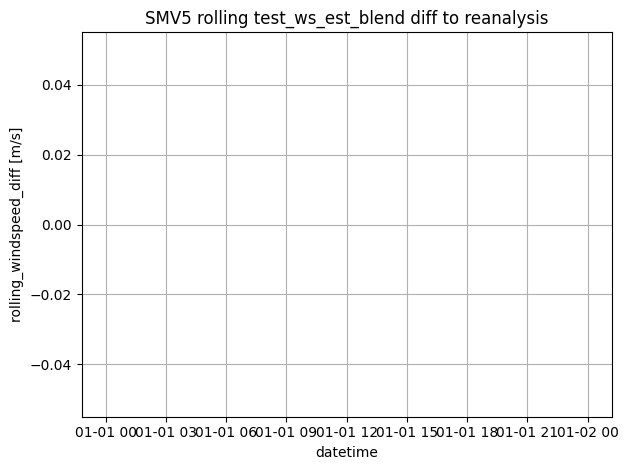

changed 2899 [5.5%] rows from toggle_on True to False because toggle_change_settling_filter_seconds = 120

changed 2828 [3.5%] rows from toggle_off True to False because toggle_change_settling_filter_seconds = 120

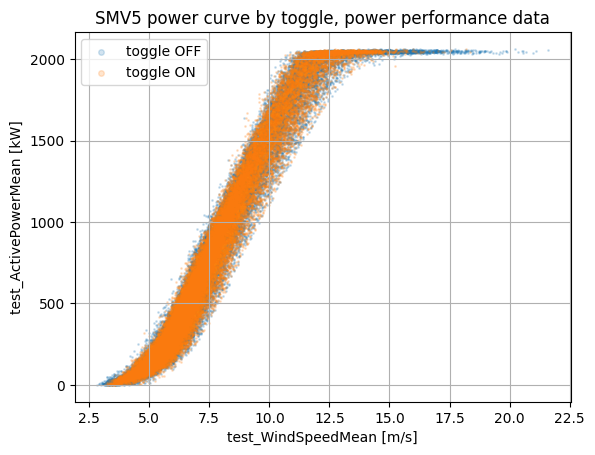

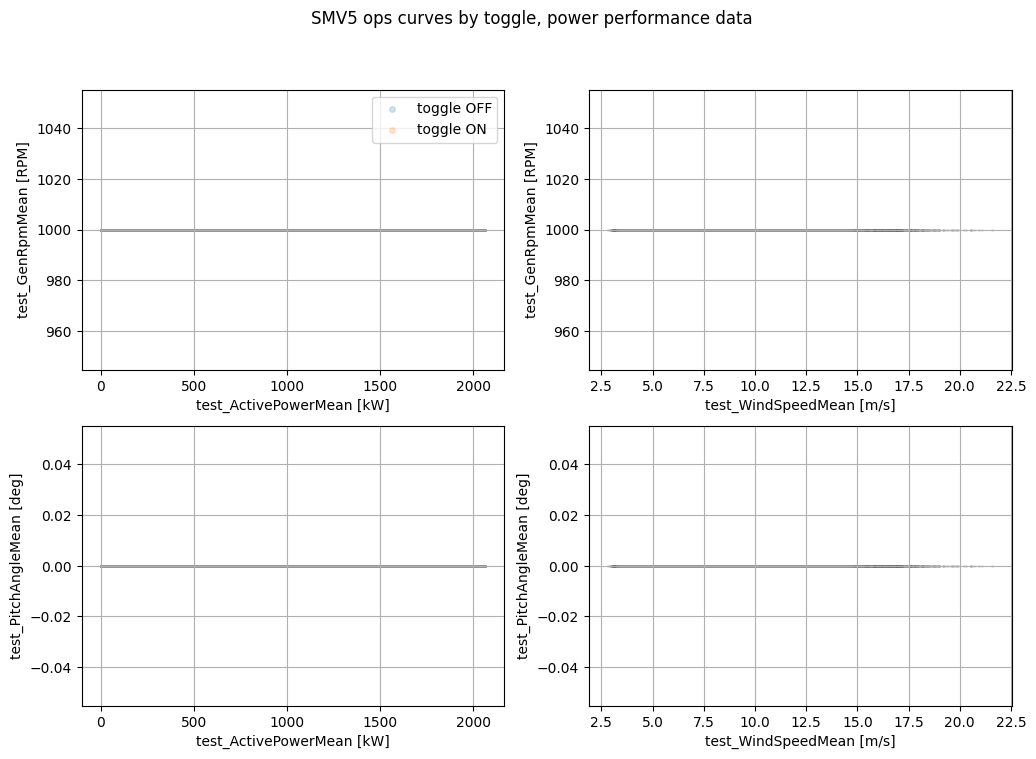

analysing SMV5 SMV7, loop_counter=1

changed 2899 [5.5%] rows from toggle_on True to False because toggle_change_settling_filter_seconds = 120

changed 2828 [3.5%] rows from toggle_off True to False because toggle_change_settling_filter_seconds = 120

removed 115061 [85.4%] rows from ref_df using ref_wd_filter

SMV7 wake free directions with data min=203.0 max=240.0

removed 0 [0.0%] rows from ref_df using require_ref_wake_free

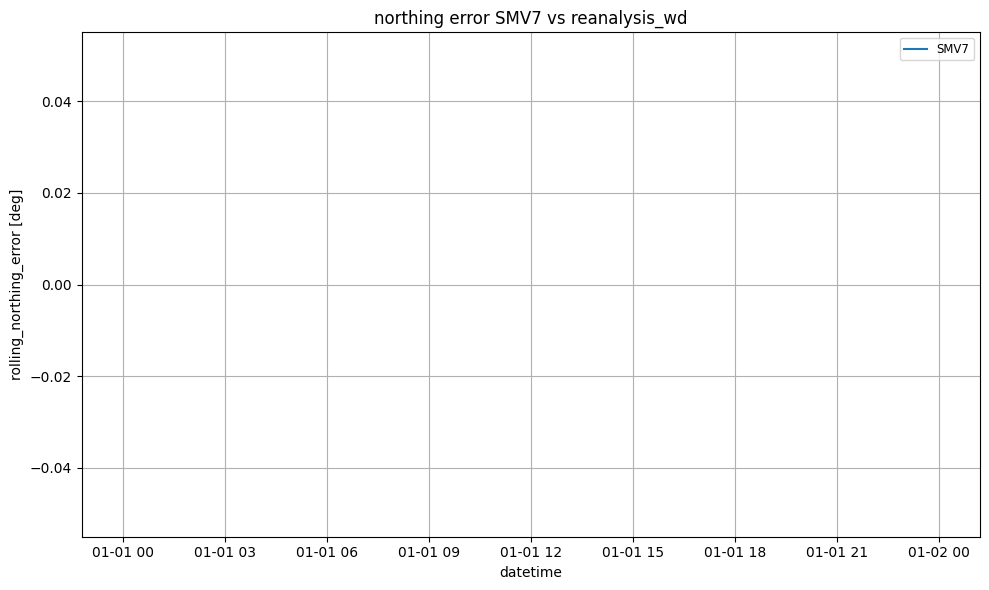

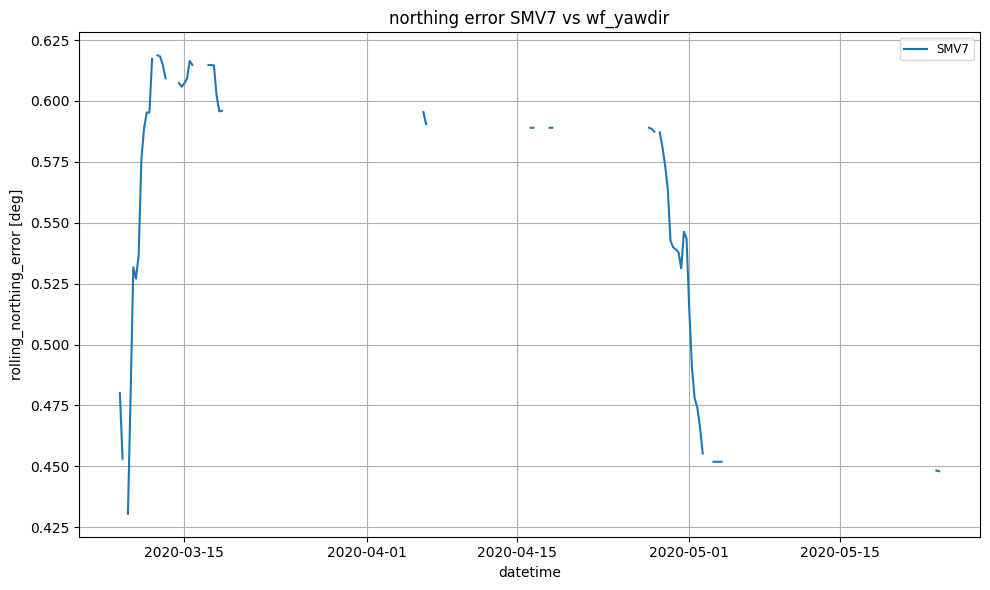

could not calculate rolling windspeed diff

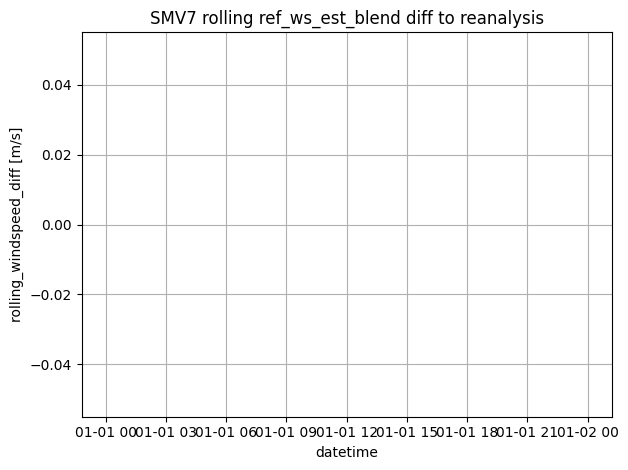

removed 55533 [41.2%] rows from detrend_df where test_toggle_off was not True after the first toggle on time

top 2 SMV5 SMV7 waking scenarios [%]:

+--------------+------+<br>| none offline | 93.7 |<br>| unknown      |  6.3 |<br>+--------------+------+

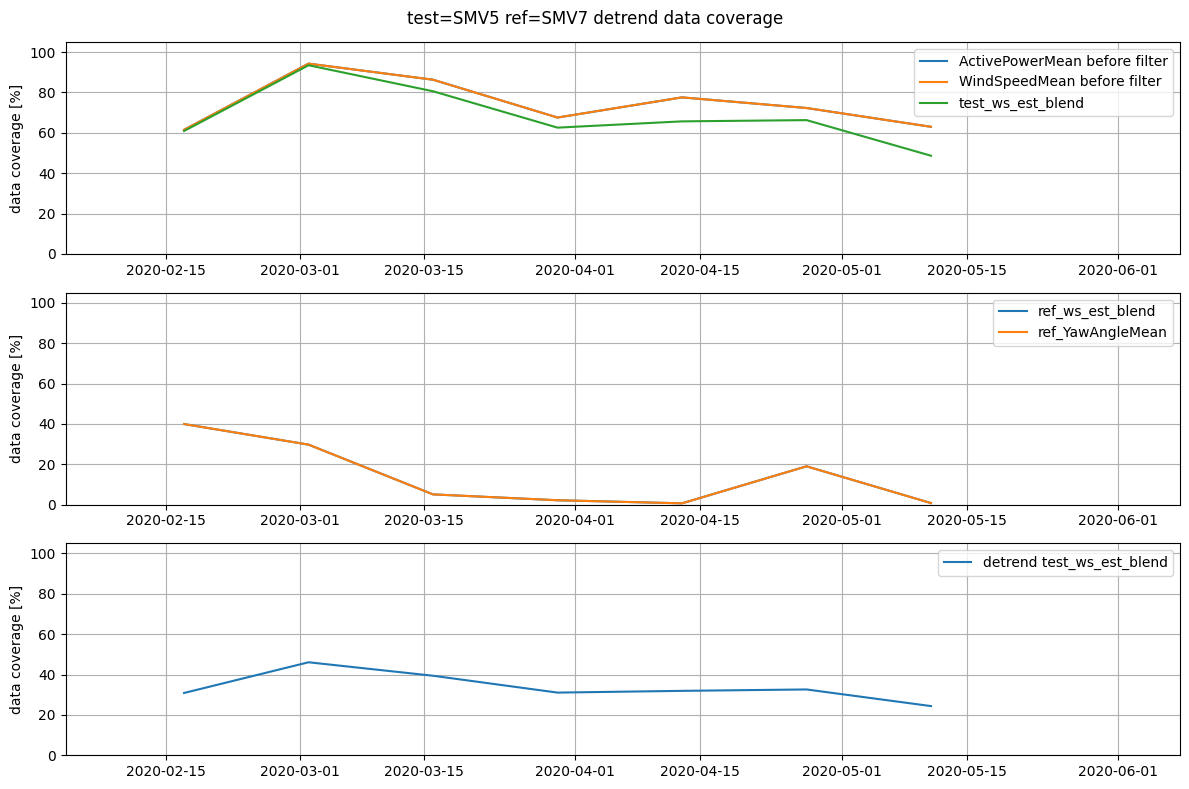

removed 0 bad detrend results

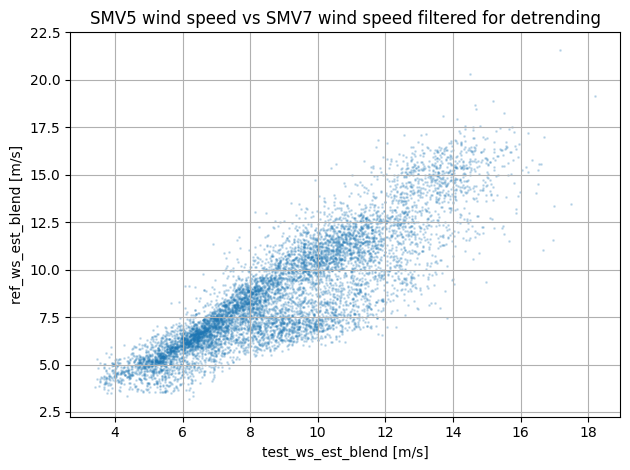

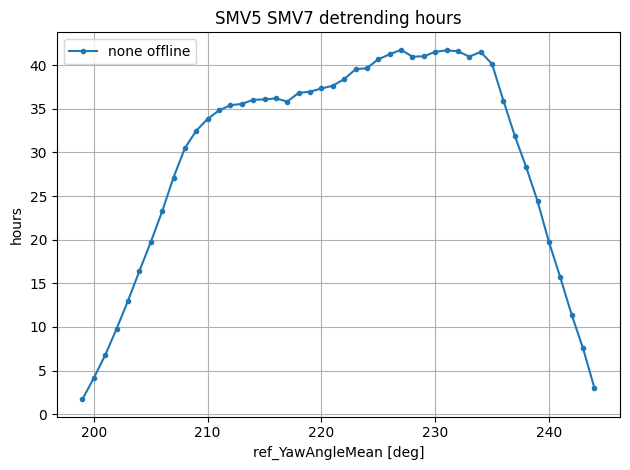

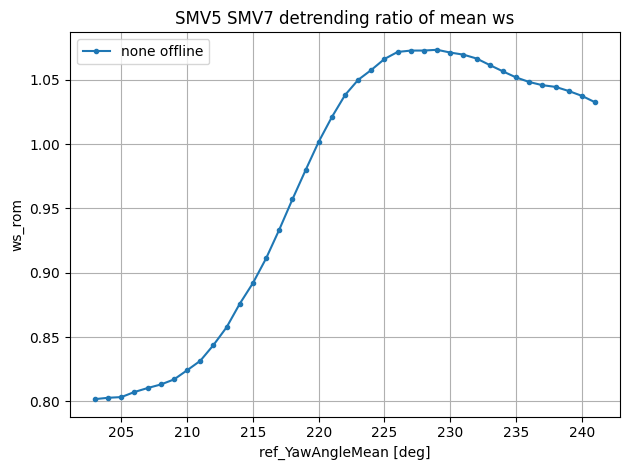

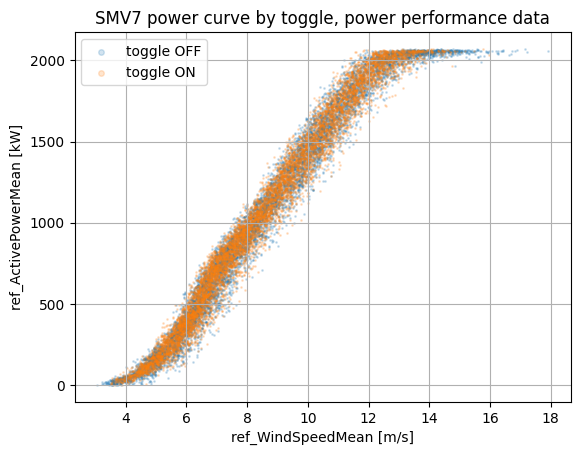

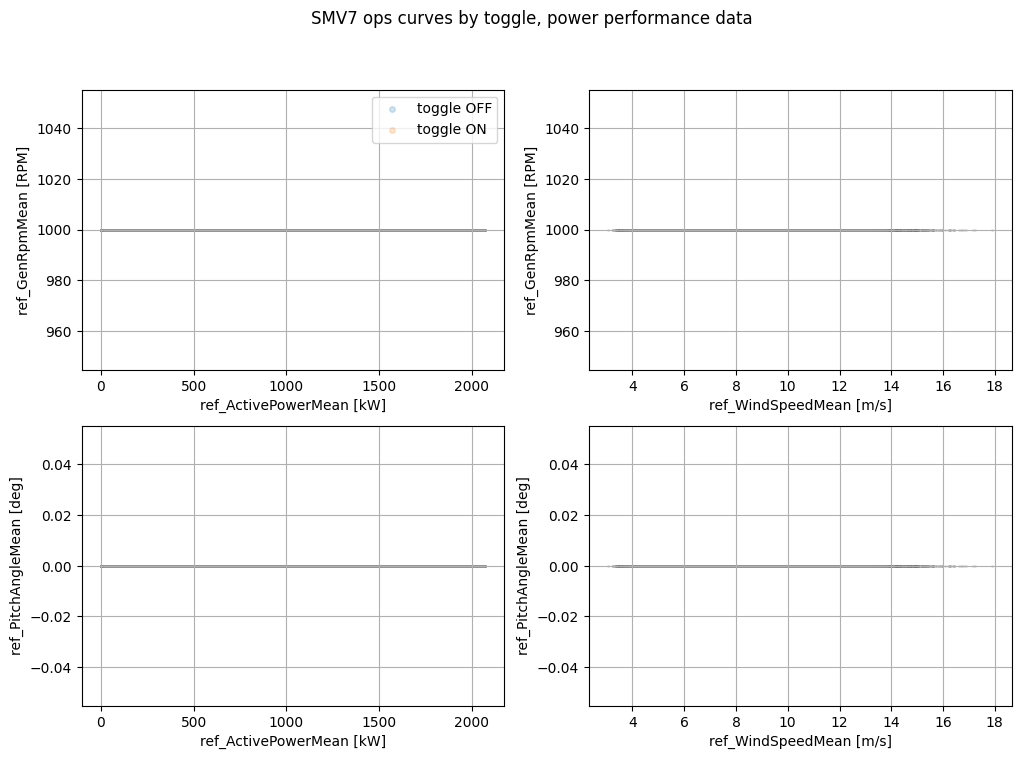

top 2 SMV5 SMV7 waking scenarios [%]:

+--------------+------+<br>| none offline | 93.7 |<br>| unknown      |  6.3 |<br>+--------------+------+

top 2 SMV5 SMV7 waking scenarios [%]:

+--------------+------+<br>| none offline | 96.7 |<br>| unknown      |  3.3 |<br>+--------------+------+

detrend applied to 73 scenario - directions

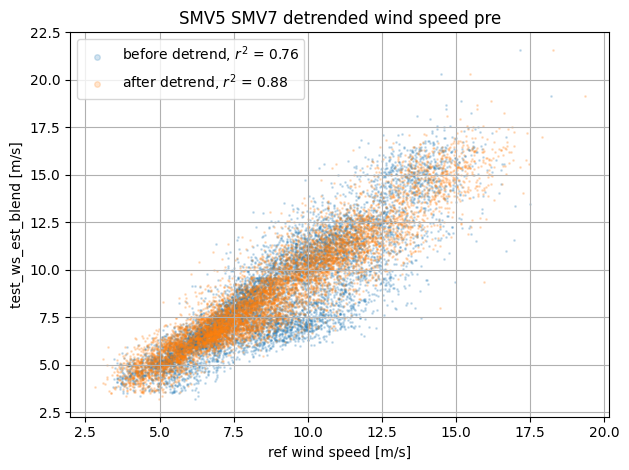

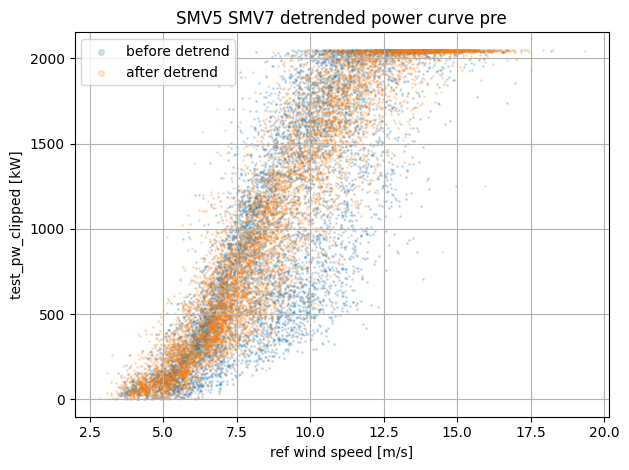

detrend applied to 72 scenario - directions

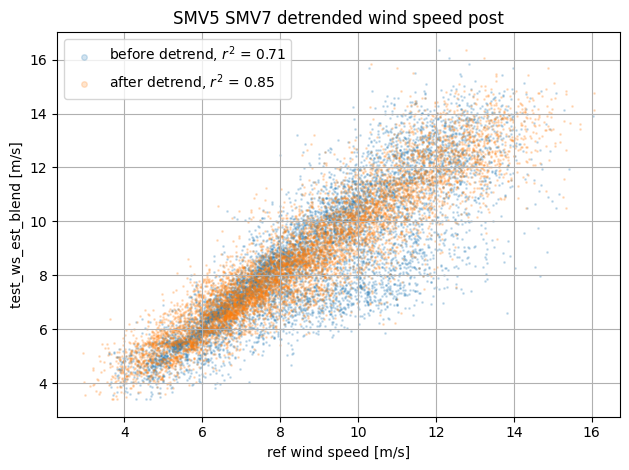

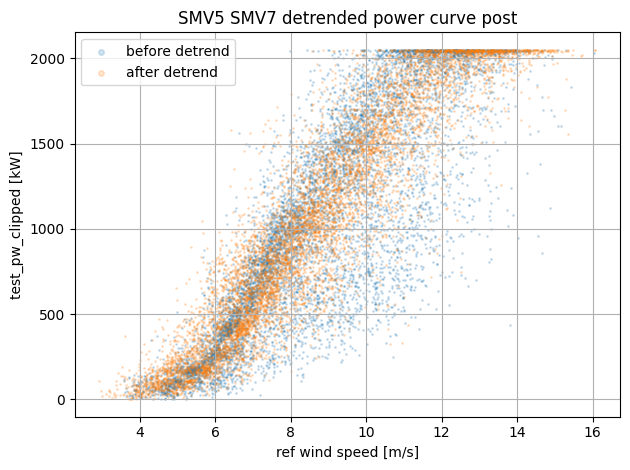

detrend improved pre_df ws r2 by 0.12 (0.76 to 0.88)

detrend improved post_df ws r2 by 0.14 (0.71 to 0.85)

removed 0 bad detrend results

removed 0 bad detrend results

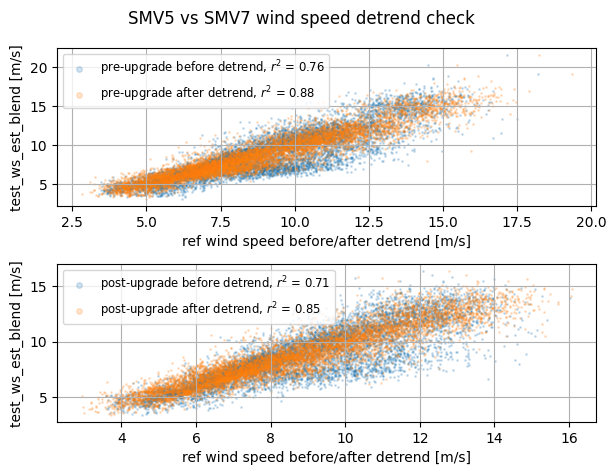

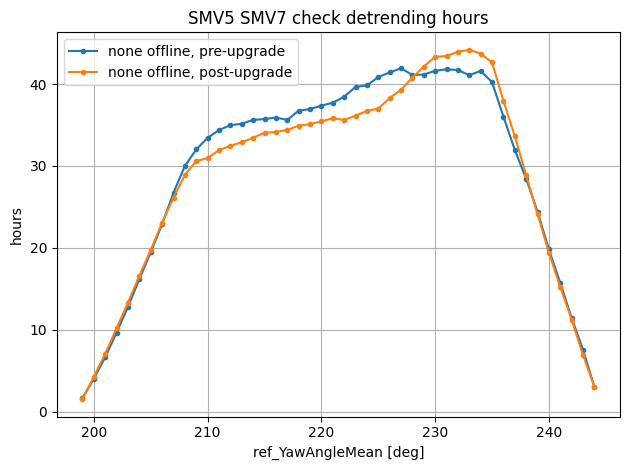

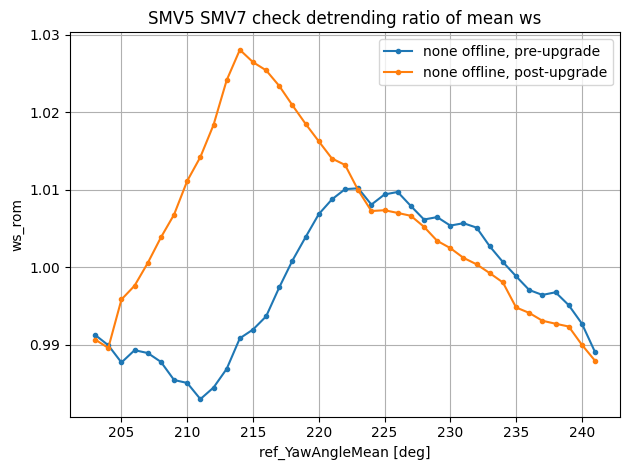

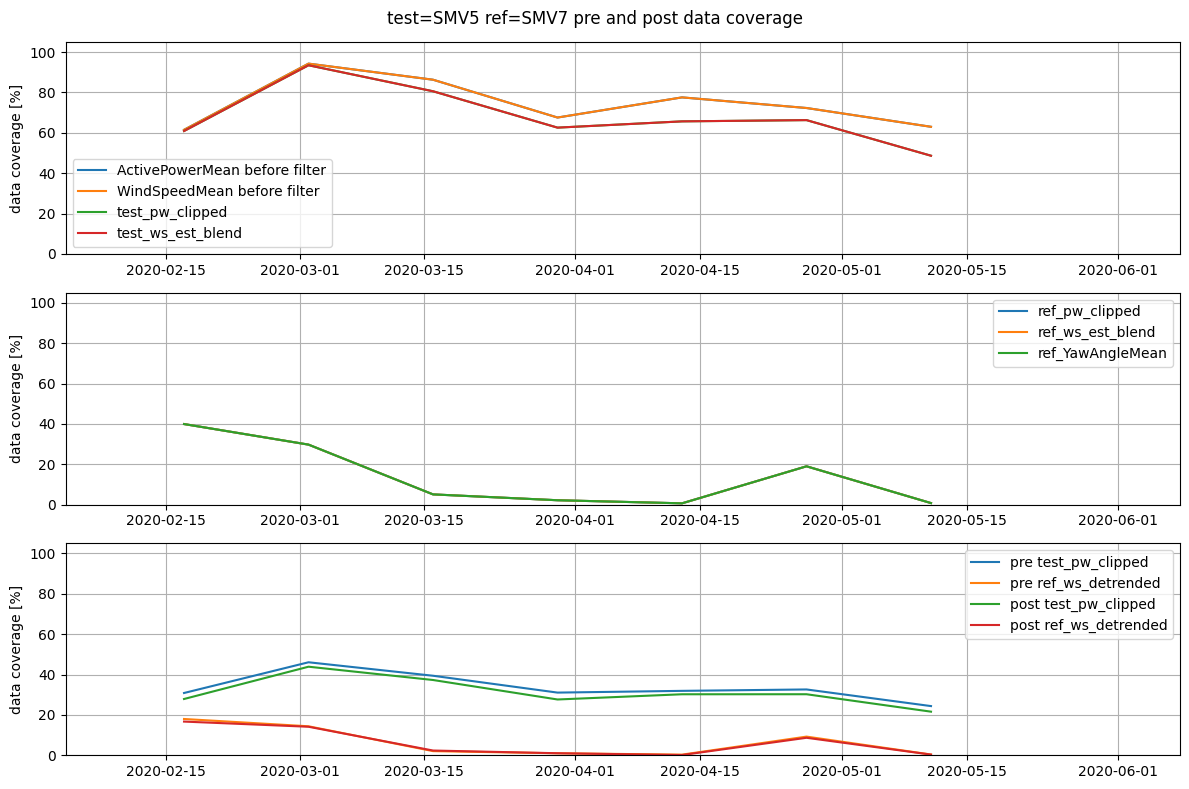

removed 262 [3.1%] rows from pre_df using any_within_timedelta pairing filter

removed 79 [1.0%] rows from post_df using any_within_timedelta pairing filter

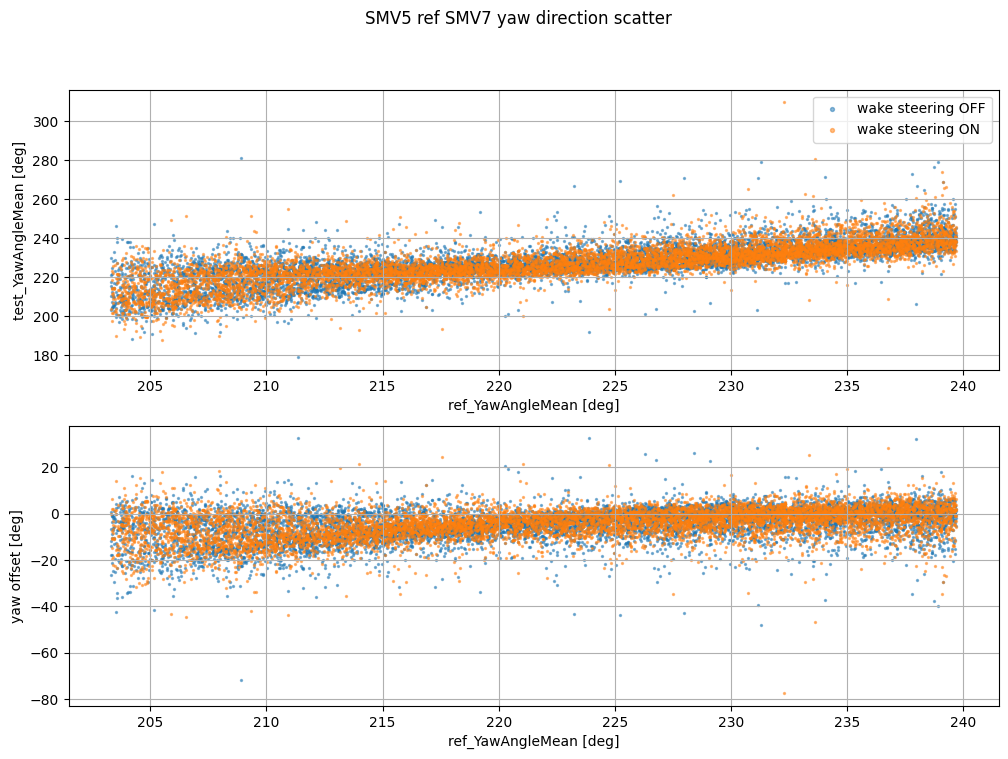

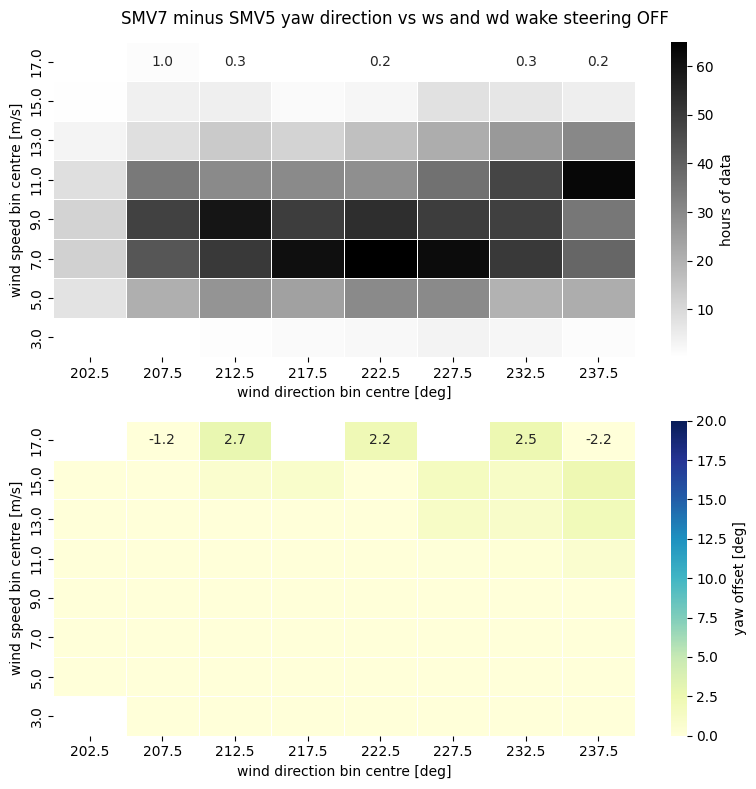

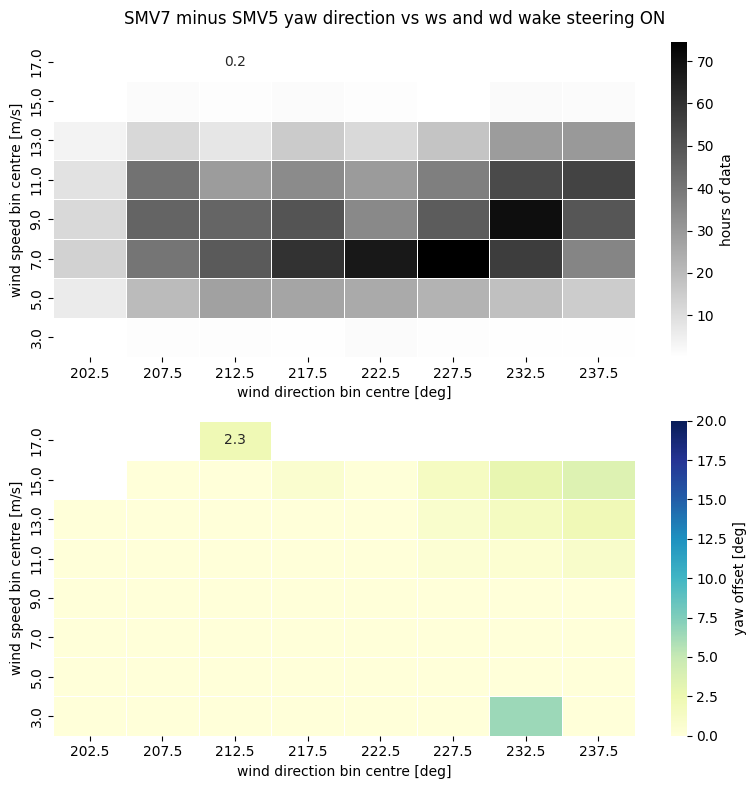

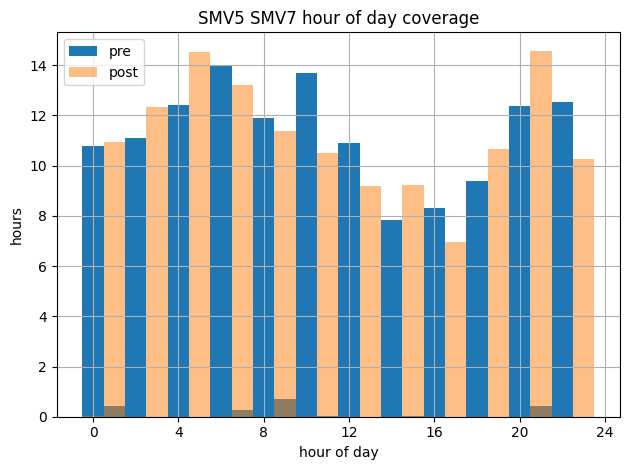

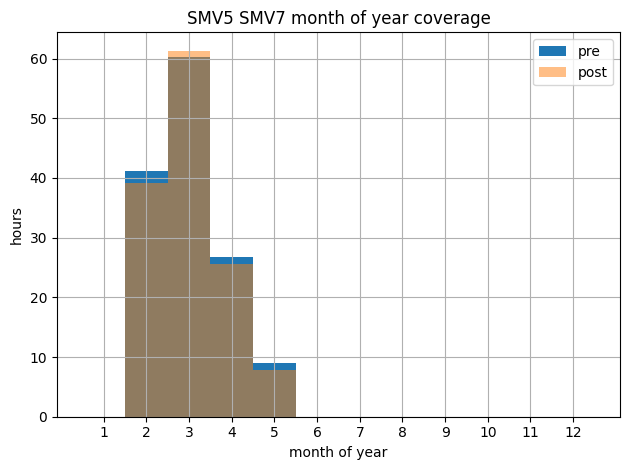

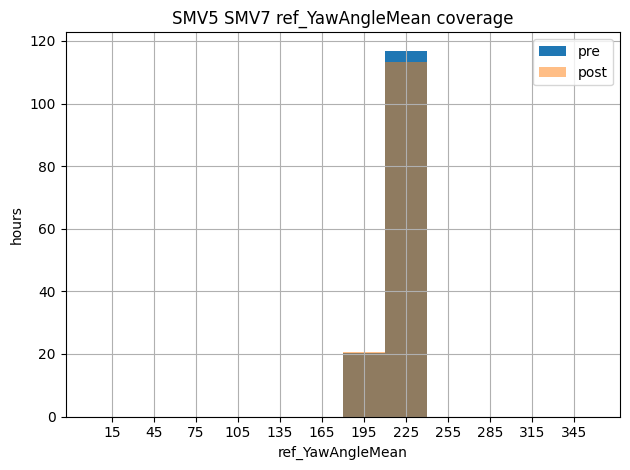

plot_pre_post_condition_histogram ref_name=SMV7 pre_df missing required column ref_AmbientTemp

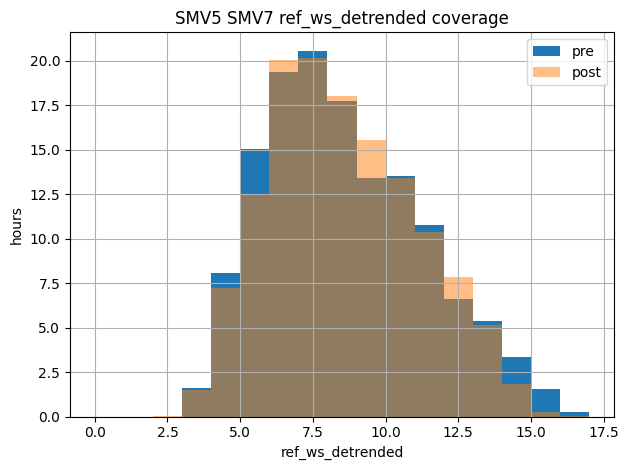

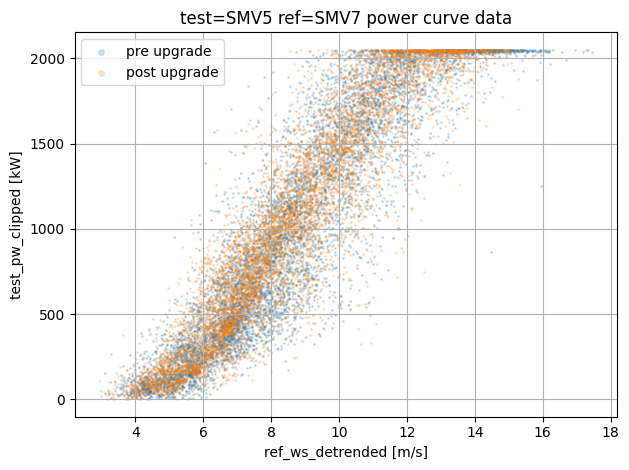

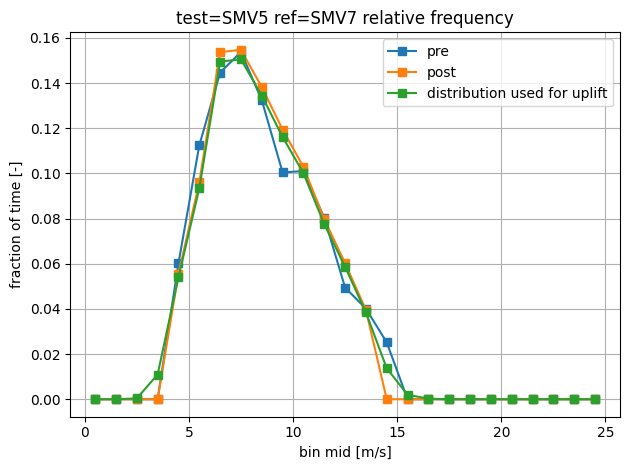

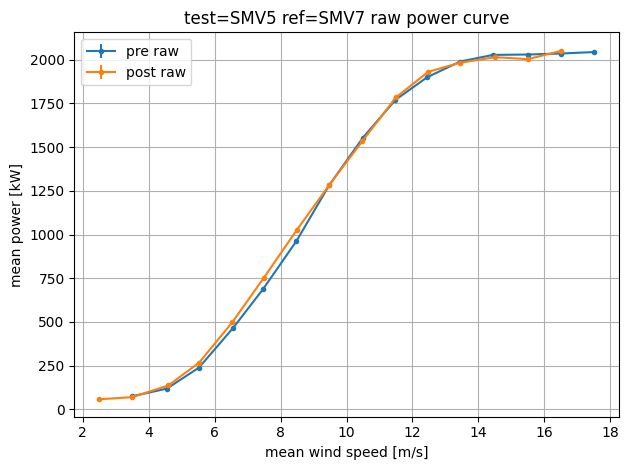

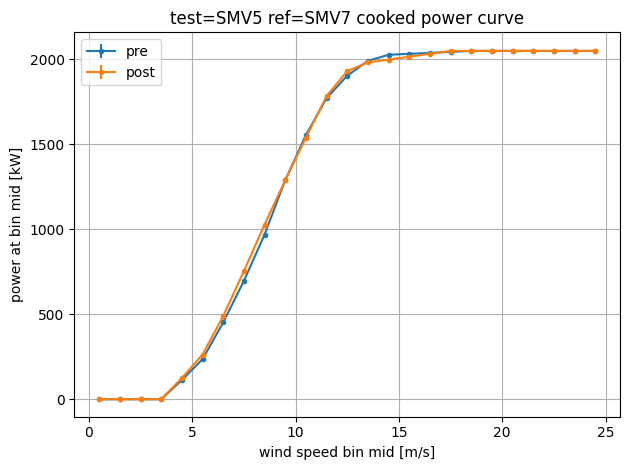

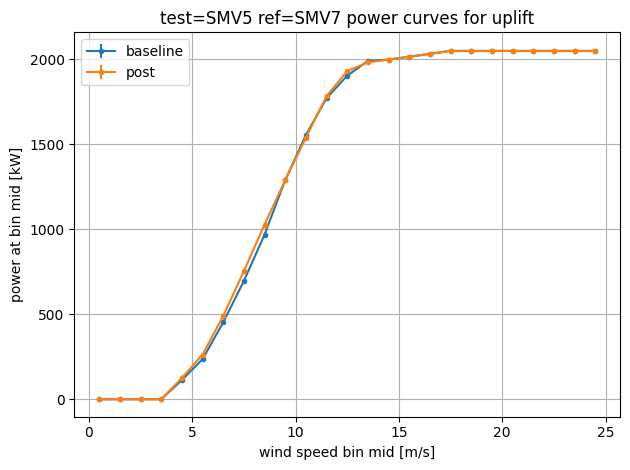

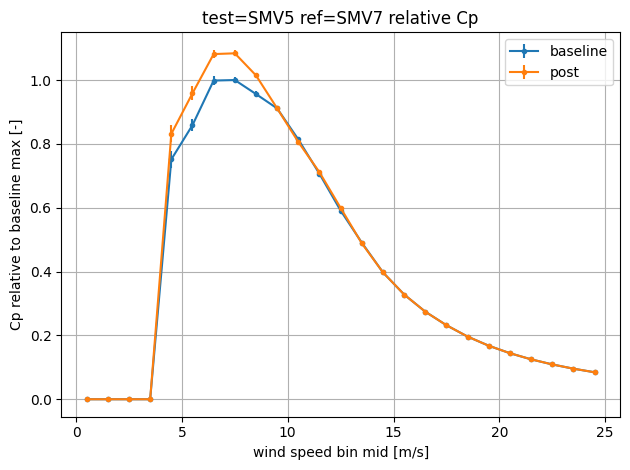

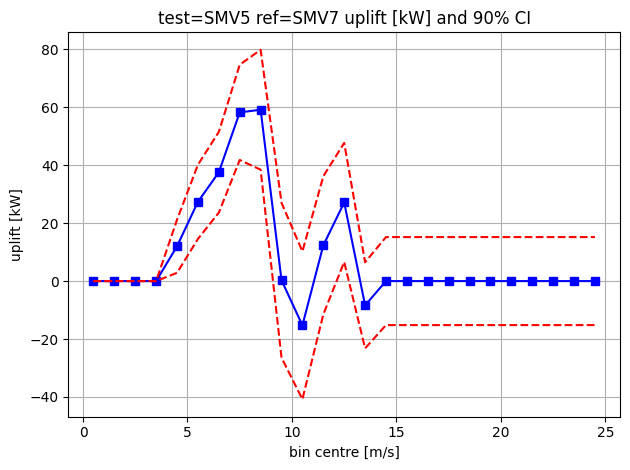

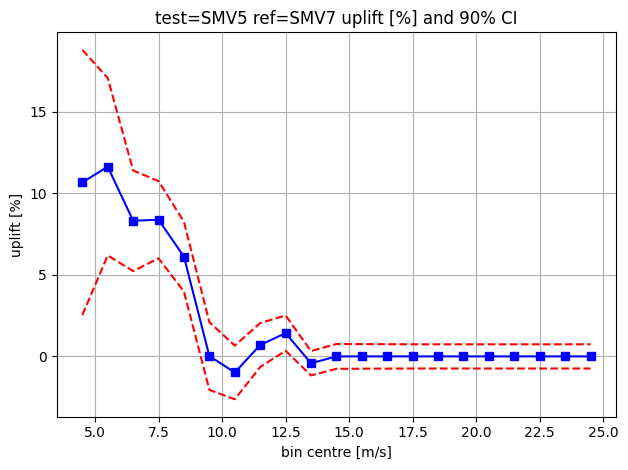

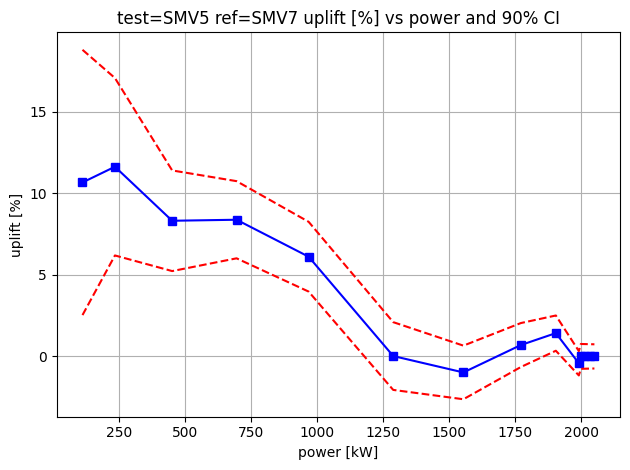

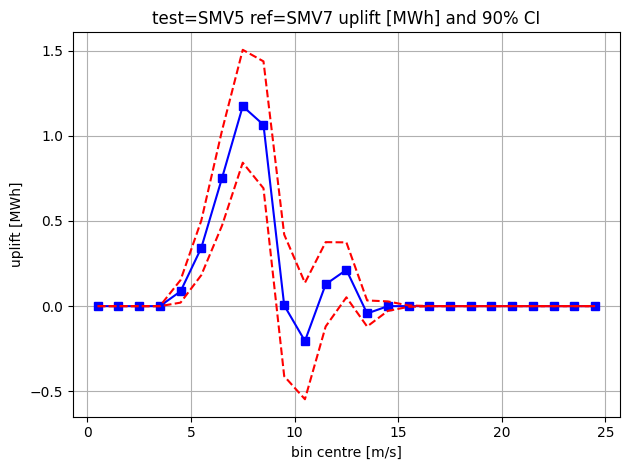

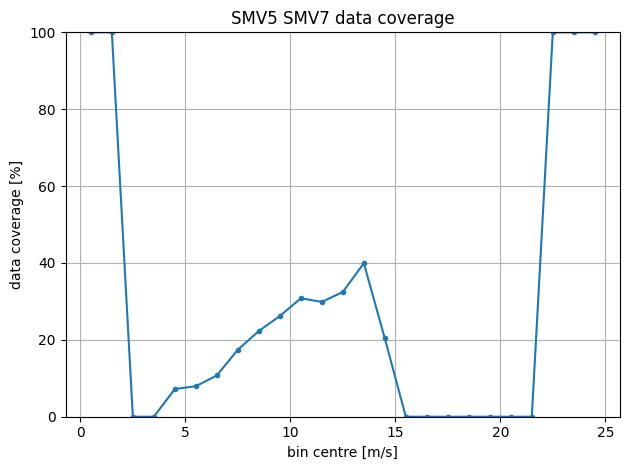

<br>results for test=SMV5 ref=SMV7:<br>

hours pre = 133.8

hours post = 130.2

<br>uplift estimate before adjustments = 2.6 %

<br>power only uplift estimate = 2.6 %

reversed (power only) uplift estimate = 2.8 %<br>

Running block bootstrapping uncertainty analysis n_samples = 400

  0%|          | 0/400 [00:00<?, ?it/s]

block bootstrapping uncertainty analysis results (conf=90%):<br>  median = 2.7 %<br>  lower = 1.3 %<br>  upper = 4.0 %<br>  unc_one_sigma = 0.8 %

<br>cat A 1 sigma unc = 0.4 %

abs reversal error / 2 = 0.1 %

bootstrap 1 sigma unc = 0.8 %

missing bins scale factor = 1.000

final 1 sigma unc = 0.8 %<br>

final uplift estimate = 2.7 %

final P95 uplift estimate = 1.4 %

final P5 uplift estimate = 4.1 %

{'ref': 'SMV7', 'ref_ws_col': 'ref_ws_est_blend', 'distance_m': 591.1178519934067, 'bearing_deg': 190.23567745703912, 'ref_max_northing_error_v_reanalysis': nan, 'ref_max_northing_error_v_wf': 0.6210088318386511, 'ref_max_ws_drift': nan, 'ref_max_ws_drift_pp_period': nan, 'ref_powercurve_shift': 0.004664394071265177, 'ref_rpm_shift': 0.0, 'ref_pitch_shift': 0.0, 'detrend_pre_r2_improvement': 0.12268759176430732, 'detrend_post_r2_improvement': 0.1405260570762782, 'mean_power_pre': 991.3518, 'mean_power_post': 1021.1067, 'mean_test_yaw_offset_pre': -4.638245, 'mean_test_yaw_offset_post': -4.3524146, 'test_ref_warning_counts': 2, 'time_calculated': Timestamp('2024-10-16 17:02:44.962877+0000', tz='UTC'), 'uplift_frc': 0.027357744113919665, 'unc_one_sigma_frc': 0.008064360299336005, 't_value_one_sigma': 1.0000639999998688, 'missing_bins_unc_scale_factor': 1, 'pp_valid_hours_pre': 133.76666666666665, 'pp_valid_hours_post': 130.23333333333335, 'pp_valid_hours': 264.0, 'pp_data_coverage': 0.11303789338471419, 'pp_invalid_bin_count': 15, 'uplift_noadj_frc': 0.026450817073874207, 'unc_one_sigma_noadj_frc': 0.0039288917301293315, 'poweronly_uplift_frc': 0.026358935680609673, 'reversed_uplift_frc': 0.02817278976070059, 'reversal_error': 0.0018138540800909167, 'unc_one_sigma_lowerbound_frc': 0.0009069270400454583, 'unc_one_sigma_bootstrap_frc': 0.008064360299336005, 'uplift_p5_frc': 0.040622436401325956, 'uplift_p95_frc': 0.014093051826513377, 'wind_up_version': '0.1.9', 'test_wtg': 'SMV5', 'test_pw_col': 'test_pw_clipped', 'lt_wtg_hours_raw': 0, 'lt_wtg_hours_filt': 0, 'test_max_ws_drift': nan, 'test_max_ws_drift_pp_period': nan, 'test_powercurve_shift': -0.007131475260499065, 'test_rpm_shift': 0.0, 'test_pitch_shift': 0.0, 'preprocess_warning_counts': 0, 'test_warning_counts': 1}

warning summary: preprocess_warning_counts=0, test_warning_counts=1, test_ref_warning_counts=2

finished analysing SMV5 SMV7<br>

In [13]:
from wind_up.main_analysis import run_wind_up_analysis

results_per_test_ref_df = run_wind_up_analysis(assessment_inputs)

# print the per turbine results as a nice table

In [14]:
from tabulate import tabulate


def print_smarteole_results(
    results_per_test_ref_df: pd.DataFrame,
    *,
    print_small_table: bool = False,
) -> None:
    key_results_df = results_per_test_ref_df[
        [
            "test_wtg",
            "ref",
            "uplift_frc",
            "unc_one_sigma_frc",
            "uplift_p95_frc",
            "uplift_p5_frc",
            "pp_valid_hours_pre",
            "pp_valid_hours_post",
            "mean_power_post",
        ]
    ]

    def _convert_frc_cols_to_pct(input_df: pd.DataFrame, dp: int = 1) -> pd.DataFrame:
        for i, col in enumerate(x for x in input_df.columns if x.endswith("_frc")):
            if i == 0:
                output_df = input_df.assign(
                    **{col: (input_df[col] * 100).round(dp).astype(str) + "%"}
                )
            else:
                output_df = output_df.assign(
                    **{col: (input_df[col] * 100).round(dp).astype(str) + "%"}
                )
            output_df = output_df.rename(columns={col: col.replace("_frc", "_pct")})
        return output_df

    print_df = _convert_frc_cols_to_pct(key_results_df).rename(
        columns={
            "test_wtg": "turbine",
            "ref": "reference",
            "uplift_pct": "energy uplift",
            "unc_one_sigma_pct": "uplift uncertainty",
            "uplift_p95_pct": "uplift P95",
            "uplift_p5_pct": "uplift P5",
            "pp_valid_hours_pre": "valid hours toggle off",
            "pp_valid_hours_post": "valid hours toggle on",
            "mean_power_post": "mean power toggle on",
        }
    )
    print_df["mean power toggle on"] = print_df["mean power toggle on"].round(0).astype("int64")
    print_df_for_tabulate = (
        print_df[
            [
                "turbine",
                "reference",
                "energy uplift",
                "uplift P95",
                "uplift P5",
                "valid hours toggle on",
            ]
        ]
        if print_small_table
        else print_df
    )
    results_table = tabulate(
        print_df_for_tabulate,
        headers="keys",
        tablefmt="outline",
        floatfmt=".1f",
        numalign="center",
        stralign="center",
        showindex=False,
    )
    print(results_table)


print_smarteole_results(results_per_test_ref_df, print_small_table=True)

+-----------+-------------+-----------------+--------------+-------------+-------------------------+
|  turbine  |  reference  |  energy uplift  |  uplift P95  |  uplift P5  |  valid hours toggle on  |
+===========+=============+=================+==============+=============+=========================+
|   SMV6    |    SMV7     |      -1.2%      |    -2.2%     |    -0.3%    |          130.2          |
|   SMV5    |    SMV7     |      2.7%       |     1.4%     |    4.1%     |          130.2          |
+-----------+-------------+-----------------+--------------+-------------+-------------------------+


# Calculate net uplift

For wake steering we expect the steering turbine uplift to be negative and the benefitting turbine uplift to be positive (which are both true in this example). The steering turbine will almost always be more productive than the benefitting turbine since it is usually in a windier (un-waked) location, therefore the % uplift of the benefitting turbine needs to be much higher than the % loss of the steering turbine for the net uplift to be positive. The function below properly calculates the net uplift and combined uncertainty.

In [15]:
from wind_up.combine_results import calc_net_uplift

net_p50, net_p95, net_p5 = calc_net_uplift(results_per_test_ref_df, confidence=0.9)
print(f"net P50: {net_p50:.1%}, net P95: {net_p95:.1%}, net P5: {net_p5:.1%}")

net P50: 0.6%, net P95: -0.2%, net P5: 1.4%
